In [1]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from tabulate import tabulate
from matplotlib.ticker import MaxNLocator
import warnings
from IPython.display import HTML
from IPython.display import clear_output
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Define Input Data from Excel File
def load_data(file_path, N_a):
    df = pd.read_excel(file_path, sheet_name="Agents", usecols="B:Q", nrows=N_a+1)
    Agents = {(i+1, j+1): df.iloc[i, j].tolist() for i in range(N_a) for j in range(8)} 
    Types = {(i+1, j-7): df.iloc[i, j].tolist() for i in range(N_a) for j in range(8,16)}
    Data_Hourly = pd.read_excel(file_path, sheet_name="Hourly Data", usecols="B:E", nrows=25)
    Data_Hourly.index = range(1, len(Data_Hourly) + 1)
    Data_HE_TypeA = pd.read_excel(file_path, sheet_name="HE_TypeA", usecols="B:I", nrows=N_a+1)
    Data_HE_TypeA.index = range(1, len(Data_HE_TypeA) + 1)
    Data_HE_TypeB = pd.read_excel(file_path, sheet_name="HE_TypeB", usecols="B:E", nrows=4)
    Data_HE_TypeB.index = range(1, len(Data_HE_TypeB) + 1)
    Data_HE_TypeC = pd.read_excel(file_path, sheet_name="HE_TypeC", usecols="B:B", nrows=4)
    Data_HE_TypeC.index = range(1, len(Data_HE_TypeC) + 1)   
    Data_RU_TypeA = pd.read_excel(file_path, sheet_name="RU_TypeA", usecols="B:D", nrows=4)
    Data_RU_TypeA.index = range(1, len(Data_RU_TypeA) + 1)   
    Data_RU_TypeB = pd.read_excel(file_path, sheet_name="RU_TypeB", usecols="B:D", nrows=4)
    Data_RU_TypeB.index = range(1, len(Data_RU_TypeB) + 1)   
    Data_RU_TypeC = pd.read_excel(file_path, sheet_name="RU_TypeC", usecols="B:E", nrows=5)
    Data_RU_TypeC.index = range(1, len(Data_RU_TypeC) + 1)
    Data_RU_TypeD = pd.read_excel(file_path, sheet_name="RU_TypeD", usecols="B:F", nrows=5)
    Data_RU_TypeD.index = range(1, len(Data_RU_TypeD) + 1)
    Data_TU = pd.read_excel(file_path, sheet_name="TU", usecols="B:I", nrows=9)
    Data_TU.index = range(1, len(Data_TU) + 1)
    return Agents, Types, Data_HE_TypeA, Data_HE_TypeB, Data_RU_TypeC, Data_RU_TypeB, Data_RU_TypeA, Data_TU, Data_HE_TypeC, Data_RU_TypeD, Data_Hourly

In [3]:
# Load Data from Excel File
N_a = 31
file_path = "SimData_Site.xlsx"
Agents, Types, Data_HE_TypeA, Data_HE_TypeB, Data_RU_TypeC, Data_RU_TypeB, Data_RU_TypeA, Data_TU, Data_HE_TypeC, Data_RU_TypeD, Data_Hourly = load_data(file_path, N_a)

In [4]:
# Definition of Agents
model = ConcreteModel()
model.agent = RangeSet(1, N_a)
model.e = RangeSet(1, 1)
model.t = RangeSet(1, 24)
model.iter = RangeSet(1, 2000)
model.s = RangeSet(1, 10)
model.HE_TypeA = Set(initialize = [i for i in model.agent if Agents[i,1] == 1], within=model.agent)
model.HE_TypeB = Set(initialize = [i for i in model.agent if Agents[i,2] == 1], within=model.agent)
model.HE_TypeC = Set(initialize = [i for i in model.agent if Agents[i,7] == 1], within=model.agent)
model.RU_TypeA = Set(initialize = [i for i in model.agent if Agents[i,5] == 1], within=model.agent)
model.RU_TypeB = Set(initialize = [i for i in model.agent if Agents[i,4] == 1], within=model.agent)
model.RU_TypeC = Set(initialize = [i for i in model.agent if Agents[i,3] == 1], within=model.agent)
model.RU_TypeD = Set(initialize = [i for i in model.agent if Agents[i,8] == 1], within=model.agent)
model.TU = Set(initialize = [i for i in model.agent if Agents[i,6] == 1], within=model.agent)
model.P_PPA_Mix = Set(initialize=lambda model: model.RU_TypeA | model.RU_TypeD)

In [5]:
# Creating a Model for each Agent
model_HE_TypeA = ConcreteModel()
model_HE_TypeB = ConcreteModel()
model_RU_TypeC = ConcreteModel()
model_RU_TypeB = ConcreteModel()
model_RU_TypeA = ConcreteModel()
model_TU = ConcreteModel()
model_HE_TypeC = ConcreteModel()
model_RU_TypeD = ConcreteModel()

# Parameters (General)
probability = {s+1: 1/len(model.s) for s in range(len(model.s))}
values = np.linspace(100, 60, len(model.s)) / 100 
error_w = {s+1: round(val, 2) for s, val in enumerate(values)}
values = np.linspace(100, 80, len(model.s)) / 100
error_pv = {s+1: round(val, 2) for s, val in enumerate(values)}
error_mix = {s+1: 1 for s in range(len(model.s))}
model.rho = Param(initialize=0, mutable=True)
model.rho_EM = Param(initialize=0, mutable=True)
model.rho_P_PPA = Param(model.P_PPA_Mix, initialize=0, mutable=True)
model.rho_V_PPA = Param(model.RU_TypeB, initialize=0, mutable=True)
model.rho_GCM = Param(initialize=0, mutable=True)
model.rho_BHM = Param(initialize=0, mutable=True)
model.rho_UBHM = Param(initialize=0, mutable=True)
model.lambda_EM = Param(model.t, model.s, initialize=5, mutable=True)
model.lambda_V_PPA = Param(model.s, model.RU_TypeB, initialize=24, mutable=True)
model.lambda_P_PPA = Param(model.s, model.P_PPA_Mix, initialize=16, mutable=True)
model.lambda_GCM = Param(model.s, initialize=1, mutable=True)
model.lambda_H2_BD = Param(model.t, model.s, initialize=0, mutable=True)
model.lambda_H2_UBD = Param(model.t, model.s, initialize=0, mutable=True)
model.lambda_EM_Old = Param(model.t, model.s, mutable=True)
model.lambda_V_PPA_Old = Param(model.s, model.RU_TypeB, mutable=True)
model.lambda_P_PPA_Old = Param(model.s, model.P_PPA_Mix, mutable=True)
model.lambda_GCM_Old = Param(model.s, mutable=True)
model.lambda_H2_BD_Old = Param(model.t, model.s, mutable=True)
model.lambda_H2_UBD_Old = Param(model.t, model.s, mutable=True)
model.RoM_EM = Param(model.t, initialize=lambda model, t: 550 * Data_Hourly.at[t,'Load'])
model.RoM_P_PPA = Param(model.P_PPA_Mix, initialize=0)
model.RoM_V_PPA = Param(model.RU_TypeB, initialize=0)
model.RoM_GCM = Param(initialize=3600)
model.RoM_BHM = Param(model.t, initialize=20)
model.RoM_UBHM = Param(model.t, initialize=20)
model.dt = Param(initialize=1)
model.Wind = Param(model.t, model.s, initialize=lambda model, t, s: Data_Hourly.at[t,'Wind'])
model.PV = Param(model.t, model.s, initialize=lambda model, t, s: Data_Hourly.at[t,'PV'])
model.F_Mix = Param(model.t, model.s, initialize=lambda model, t, s: Data_Hourly.at[t,'Mix'])
model.gamma_GOs = Param(initialize=1)
model.Conf = Param(initialize=0.98)
model.alpha_Loss = Param(initialize=0.05)
model.Beta = Param(initialize=0.6)
model.lambda_GA_TR = Param(initialize=8)
model.Prob = Param(model.s, initialize=lambda model, s: probability[s])
model.Alpha_Tuning_EM = Param(initialize=0.5)
model.Alpha_Tuning_P_PPA = Param(initialize=0.5)
model.Alpha_Tuning_V_PPA = Param(initialize=0.5)
model.Alpha_Tuning_BHM = Param(initialize=0.1)
model.Alpha_Tuning_UBHM = Param(initialize=0.1)
model.Alpha_Tuning_GCM = Param(initialize=0.01)
model.Beta_Tuning_EM = Param(initialize=1)
model.Beta_Tuning_P_PPA = Param(initialize=1)
model.Beta_Tuning_V_PPA = Param(initialize=1)
model.Beta_Tuning_BHM = Param(initialize=1)
model.Beta_Tuning_UBHM = Param(initialize=1)
model.Beta_Tuning_GCM = Param(initialize=0.5)
model.PF = Param(model.P_PPA_Mix | model.RU_TypeB, model.t, model.s, initialize=0, mutable=True)
model.Error = Param(model.P_PPA_Mix | model.RU_TypeB, model.s, initialize=0, mutable=True)

# Parameters (HE_TypeA)
model_HE_TypeA.qbar_EM = Param(model.HE_TypeA, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeA.qbar_P_PPA = Param(model.HE_TypeA, model.s, model.P_PPA_Mix, initialize=0, mutable=True)
model_HE_TypeA.qbar_V_PPA = Param(model.HE_TypeA, model.s, model.RU_TypeB, initialize=0, mutable=True)
model_HE_TypeA.qbar_GCM = Param(model.HE_TypeA, model.s, initialize=0, mutable=True)
model_HE_TypeA.qbar_BHM = Param(model.HE_TypeA, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeA.qbar_UBHM = Param(model.HE_TypeA, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeA.eta_P_H2 = Param(model.HE_TypeA, model.e, initialize=lambda model, a, e: Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'Efficiency'])
model_HE_TypeA.Q_Wind_Max = Param(model.HE_TypeA, model.e, initialize=lambda model, a, e: Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'Wind'])
model_HE_TypeA.Q_PV_Max = Param(model.HE_TypeA, model.e, initialize=lambda model, a, e: Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'PV'])
model_HE_TypeA.eta_EES_Ch = Param(initialize=0.95)
model_HE_TypeA.eta_EES_Dis = Param(initialize=0.95)
model_HE_TypeA.Ch_Max = Param(model.HE_TypeA, model.e, initialize=lambda model, a, e: 0.1 * Data_HE_TypeA.at[e,'EES'])
model_HE_TypeA.Dis_Max = Param(model.HE_TypeA, model.e, initialize=lambda model, a, e: 0.1 * Data_HE_TypeA.at[e,'EES'])
model_HE_TypeA.alpha_Green = Param(model.HE_TypeA, initialize=0.42)
model_HE_TypeA.E_EES_Max = Param(model.HE_TypeA, model.e, initialize=lambda model, a, e: Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EES'])
model_HE_TypeA.Q_DSP = Param(model.HE_TypeA, model.e, model.t, initialize=lambda model, a, e, t: Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'DSP'])
model_HE_TypeA.pi_CH4 = Param(initialize=0.87)
model_HE_TypeA.pi_H2O = Param(initialize=0.15)
model_HE_TypeA.pi_Heat = Param(initialize=0.87)
model_HE_TypeA.w_CH4 = Param(initialize=2)
model_HE_TypeA.w_H2O = Param(initialize=4.5)
model_HE_TypeA.w_Heat = Param(initialize=2.5)

# Variables (HE_TypeA)
model_HE_TypeA.q_EM_Portfolio = Var(model.HE_TypeA, model.t, model.s)
model_HE_TypeA.q_P_PPA = Var(model.HE_TypeA, model.s, model.P_PPA_Mix, bounds=lambda model, a, s, aa: (-0.1 * sum(Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EL_Max'] for e in RangeSet(1, 1)), 0))
model_HE_TypeA.q_V_PPA = Var(model.HE_TypeA, model.s, model.RU_TypeB, bounds=lambda model, a, s, aa: (-0.095 * sum(Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EL_Max'] for e in RangeSet(1, 1)), 0))
model_HE_TypeA.q_GCM_Portfolio = Var(model.HE_TypeA, model.s)
model_HE_TypeA.q_BHM_Portfolio = Var(model.HE_TypeA, model.t, model.s)
model_HE_TypeA.q_UBHM_Portfolio = Var(model.HE_TypeA, model.t, model.s)
model_HE_TypeA.c_SMR = Var(model.HE_TypeA, model.t, model.s)
model_HE_TypeA.q_P_EL = Var(model.HE_TypeA, model.e, model.t, model.s, bounds=lambda model, a, e, t, s: (Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EL_Min'], Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EL_Max']))
model_HE_TypeA.q_H_EL = Var(model.HE_TypeA, model.e, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeA.q__P_PPA = Var(model.HE_TypeA, model.e, model.s, model.P_PPA_Mix, domain=NonPositiveReals)
model_HE_TypeA.q_EM = Var(model.HE_TypeA, model.e, model.t, model.s)
model_HE_TypeA.q__V_PPA = Var(model.HE_TypeA, model.e, model.s, model.RU_TypeB, domain=NonPositiveReals)
model_HE_TypeA.q_Local = Var(model.HE_TypeA, model.e, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeA.q_Dis = Var(model.HE_TypeA, model.e, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeA.q_Ch = Var(model.HE_TypeA, model.e, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeA.e_EES = Var(model.HE_TypeA, model.e, model.t, model.s, bounds=lambda model, a, e, t, s: (0.1 * Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EES'], 
                                                                                                        Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EES']))
model_HE_TypeA.i_ESS = Var(model.HE_TypeA, model.e, model.t, model.s, domain=Binary, initialize=0)
model_HE_TypeA.q_EES = Var(model.HE_TypeA, model.e, model.t, model.s)
model_HE_TypeA.q_BHM = Var(model.HE_TypeA, model.e, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeA.q_UBHM = Var(model.HE_TypeA, model.e, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeA.q_GCM = Var(model.HE_TypeA, model.e, model.s)
model_HE_TypeA.q_DSP = Var(model.HE_TypeA, model.e, model.t, model.s, bounds=lambda model, a, e, t, s: ((1-Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'Flexibility']) 
                                                                                                        * Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'DSP'], 
                                                                                                        (1+Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'Flexibility']) 
                                                                                                        * Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'DSP']))
model_HE_TypeA.q_H_SMR = Var(model.HE_TypeA, model.e, model.t, model.s, bounds=lambda model, a, e, t, s: (0, 0.15 * 20 * Data_HE_TypeA.at[next(col for col in range(1, 6) if Types[(a, col)] == 1),'EL_Max']))
model_HE_TypeA.Z_HE_TypeA = Var(model.HE_TypeA, model.s)
model_HE_TypeA.P_PPA_VaR = Var(model.HE_TypeA, model.P_PPA_Mix, domain=NonPositiveReals)
model_HE_TypeA.V_PPA_VaR = Var(model.HE_TypeA, model.RU_TypeB, domain=NonPositiveReals)
model_HE_TypeA.f_CVaR = Var(model.HE_TypeA)
model_HE_TypeA.P_PPA_CVaR = Var(model.HE_TypeA, model.P_PPA_Mix)
model_HE_TypeA.V_PPA_CVaR = Var(model.HE_TypeA, model.RU_TypeB)
model_HE_TypeA.delta_P_PPA = Var(model.HE_TypeA, model.P_PPA_Mix, model.s, domain=NonNegativeReals)
model_HE_TypeA.delta_V_PPA = Var(model.HE_TypeA, model.RU_TypeB, model.s, domain=NonNegativeReals)

# Parameters (HE_TypeB)
model_HE_TypeB.qbar_EM = Param(model.HE_TypeB, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeB.qbar_P_PPA = Param(model.HE_TypeB, model.s, model.P_PPA_Mix, initialize=0, mutable=True)
model_HE_TypeB.qbar_V_PPA = Param(model.HE_TypeB, model.s, model.RU_TypeB, initialize=0, mutable=True)
model_HE_TypeB.qbar_GCM = Param(model.HE_TypeB, model.s, initialize=0, mutable=True)
model_HE_TypeB.qbar_BHM = Param(model.HE_TypeB, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeB.qbar_UBHM = Param(model.HE_TypeB, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeB.eta_P_H2 = Param(model.HE_TypeB, initialize=lambda model, a: Data_HE_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1), 'Efficiency'])
model_HE_TypeB.Q_DSP = Param(model.HE_TypeB, model.t, initialize=lambda model, a, t: Data_HE_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1), 'DSP'])
model_HE_TypeB.alpha_Green = Param(model.HE_TypeB, initialize=0.42)

# Variables (HE_TypeB)
model_HE_TypeB.q_EM = Var(model.HE_TypeB, model.t, model.s)
model_HE_TypeB.q_P_PPA = Var(model.HE_TypeB, model.s, model.P_PPA_Mix, domain=NonPositiveReals,  bounds=lambda model, a, s, aa: (-0.1 * Data_HE_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1), 'EL_Max'], 0))
model_HE_TypeB.q_V_PPA = Var(model.HE_TypeB, model.s, model.RU_TypeB, domain=NonPositiveReals,  bounds=lambda model, a, s, aa: (-0.095 * Data_HE_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1), 'EL_Max'], 0))
model_HE_TypeB.q_GCM = Var(model.HE_TypeB, model.s)
model_HE_TypeB.q_BHM = Var(model.HE_TypeB, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeB.q_UBHM = Var(model.HE_TypeB, model.t, model.s, domain=NonNegativeReals)
model_HE_TypeB.q_P_EL = Var(model.HE_TypeB, model.t, model.s, bounds=lambda model, a, t, s: (Data_HE_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'EL_Min'], 
                                                                      Data_HE_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1), 'EL_Max']))
model_HE_TypeB.q_H_EL = Var(model.HE_TypeB, model.t, model.s)

# Parameters (HE_TypeC)
model_HE_TypeC.qbar_GCM = Param(model.HE_TypeC, model.s, initialize=0, mutable=True)
model_HE_TypeC.qbar_BHM = Param(model.HE_TypeC, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeC.qbar_UBHM = Param(model.HE_TypeC, model.t, model.s, initialize=0, mutable=True)
model_HE_TypeC.eta_P_H2 = Param(initialize=20)
model_HE_TypeC.Q_DSP = Param(model.HE_TypeC, model.t, initialize=lambda model, a, t: Data_HE_TypeC.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'DSP'])
model_HE_TypeC.alpha_Green = Param(model.HE_TypeC, initialize=0.42)

# Variables (HE_TypeC)
model_HE_TypeC.q_GCM = Var(model.HE_TypeC, model.s, domain=NonPositiveReals)
model_HE_TypeC.q_BHM = Var(model.HE_TypeC, model.t, model.s, domain=NonPositiveReals)
model_HE_TypeC.q_UBHM = Var(model.HE_TypeC, model.t, model.s, domain=NonPositiveReals)

# Parameters (RU_TypeA)
model_RU_TypeA.qbar_P_PPA = Param(model.RU_TypeA, model.s, initialize=0, mutable=True)
model_RU_TypeA.Pi_P_PPA_Min = Param(model.RU_TypeA, initialize=lambda model, a: Data_RU_TypeA.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'P_PPA_Min'])
model_RU_TypeA.Q_Ren_Max = Param(model.RU_TypeA, initialize=lambda model, a: Data_RU_TypeA.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Capacity'])
for a in model.RU_TypeA:
    if  Data_RU_TypeA.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Type'] == 1:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.Wind[t, s]
                model.Error[a, s] = error_w[s]
    if  Data_RU_TypeA.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Type'] == 2:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.PV[t, s]
                model.Error[a, s] = error_pv[s]
    if  Data_RU_TypeA.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Type'] == 3:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.F_Mix[t, s]
                model.Error[a, s] = error_mix[s]

# Variables (RU_TypeA)
model_RU_TypeA.q_P_PPA = Var(model.RU_TypeA, model.s, domain=NonNegativeReals)

# Parameters (RU_TypeB)
model_RU_TypeB.qbar_V_PPA = Param(model.RU_TypeB, model.s, initialize=0, mutable=True)
model_RU_TypeB.Pi_V_PPA_Min = Param(model.RU_TypeB, initialize=lambda model, a: Data_RU_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'V_PPA_Min'])
model_RU_TypeB.Q_Ren_Max = Param(model.RU_TypeB, initialize=lambda model, a: Data_RU_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Capacity'])
for a in model.RU_TypeB:
    if  Data_RU_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Type'] == 1:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.Wind[t, s]
                model.Error[a, s] = error_w[s]
    if  Data_RU_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Type'] == 2:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.PV[t, s]
                model.Error[a, s] = error_pv[s]
    if  Data_RU_TypeB.at[next(col for col in range(1, 4) if Types[(a, col)] == 1),'Type'] == 3:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.F_Mix[t, s]
                model.Error[a, s] = error_mix[s]

# Variables (RU_TypeB)
model_RU_TypeB.q_V_PPA = Var(model.RU_TypeB, model.s, domain=NonNegativeReals)

# Parameters (RU_TypeC)
model_RU_TypeC.qbar_EM = Param(model.RU_TypeC, model.t, model.s, initialize=0, mutable=True)
model_RU_TypeC.qbar_GCM = Param(model.RU_TypeC, model.s, initialize=0, mutable=True)
model_RU_TypeC.Pi_EM_Min = Param(model.RU_TypeC, initialize=lambda model, a: Data_RU_TypeC.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'EM_Min'])
model_RU_TypeC.Q_Wind_Max = Param(model.RU_TypeC, initialize=lambda model, a: Data_RU_TypeC.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'Wind'])
model_RU_TypeC.Q_PV_Max = Param(model.RU_TypeC, initialize=lambda model, a: Data_RU_TypeC.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'PV'])
model_RU_TypeC.Pi_GCM_Min = Param(model.RU_TypeC, initialize=lambda model, a: Data_RU_TypeC.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'GCM_Min'])

# Variables (RU_TypeC)
model_RU_TypeC.q_EM = Var(model.RU_TypeC, model.t, model.s, domain=NonNegativeReals)
model_RU_TypeC.q_GCM = Var(model.RU_TypeC, model.s, domain=NonNegativeReals)

# Parameters (RU_TypeD)
model_RU_TypeD.qbar_EM = Param(model.RU_TypeD, model.t, model.s, initialize=0, mutable=True)
model_RU_TypeD.qbar_GCM = Param(model.RU_TypeD, model.s, initialize=0, mutable=True)
model_RU_TypeD.qbar_P_PPA = Param(model.RU_TypeD, model.s, initialize=0, mutable=True)
model_RU_TypeD.Pi_EM_Min = Param(model.RU_TypeD, initialize=lambda model, a: Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'EM_Min'])
model_RU_TypeD.Q_Ren_Max = Param(model.RU_TypeD, initialize=lambda model, a: Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'Capacity'])
model_RU_TypeD.Pi_GCM_Min = Param(model.RU_TypeD, initialize=lambda model, a: Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'GCM_Min'])
model_RU_TypeD.Pi_P_PPA_Min = Param(model.RU_TypeD, initialize=lambda model, a: Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'P_PPA_Min'])
for a in model.RU_TypeD:
    if  Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'Type'] == 1:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.Wind[t, s]
                model.Error[a, s] = error_w[s]
    if  Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'Type'] == 2:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.PV[t, s]
                model.Error[a, s] = error_pv[s]
    if  Data_RU_TypeD.at[next(col for col in range(1, 5) if Types[(a, col)] == 1),'Type'] == 3:
        for t in model.t:
            for s in model.s:
                model.PF[a,t, s] = model.F_Mix[t, s]
                model.Error[a, s] = error_mix[s]

# Variables (RU_TypeD)
model_RU_TypeD.q_EM = Var(model.RU_TypeD, model.t, model.s, domain=NonNegativeReals)
model_RU_TypeD.q_GCM = Var(model.RU_TypeD, model.s, domain=NonNegativeReals)
model_RU_TypeD.q_P_PPA = Var(model.RU_TypeD, model.s, domain=NonNegativeReals)

# Parameters (TU)
model_TU.P_Op = Param(model.TU, initialize=lambda model, a: Data_TU.at[next(col for col in range(1, 9) if Types[(a, col)] == 1),'EM_Min'])
model_TU.Q_min = Param(model.TU, initialize=lambda model, a: Data_TU.at[next(col for col in range(1, 9) if Types[(a, col)] == 1),'P_Min'])
model_TU.Q_max = Param(model.TU, initialize=lambda model, a: Data_TU.at[next(col for col in range(1, 9) if Types[(a, col)] == 1),'P_Max'])
model_TU.Q_RU = Param(model.TU, initialize=lambda model, a: Data_TU.at[next(col for col in range(1, 9) if Types[(a, col)] == 1),'RU'])
model_TU.Q_RD = Param(model.TU, initialize=lambda model, a: Data_TU.at[next(col for col in range(1, 9) if Types[(a, col)] == 1),'RD'])
model_TU.qbar_EM = Param(model.TU, model.t, model.s, initialize=0, mutable=True)

# Variables (TU)
model_TU.q_EM = Var(model.TU, model.t, model.s, domain=NonNegativeReals)
model_TU.i_UC = Var(model.TU, model.t, model.s, domain=Binary)

In [6]:
# General Constraints for Scenario Equality
def add_equal_across_s_constraint(model, var, var_name, s_pos):
    s_vals = sorted(set(idx[s_pos] for idx in var.index_set()))
    base_index_set = set()
    for full_idx in var:
        idx = list(full_idx)
        del idx[s_pos]
        base_index_set.add(tuple(idx))
    def rule(m, *idx_base_and_k):
        idx_base = idx_base_and_k[:-1]
        k = idx_base_and_k[-1]
        idx1 = list(idx_base)
        idx2 = list(idx_base)
        idx1.insert(s_pos, s_vals[k])
        idx2.insert(s_pos, s_vals[k+1])
        return var[tuple(idx1)] == var[tuple(idx2)]
    model.add_component(
        f"EqualAcrossS_{var_name}",
        Constraint(
            list((base_idx + (k,) for base_idx in base_index_set for k in range(len(s_vals) - 1))),
            rule=rule
        )
    )

In [7]:
# Objectives (HE_TypeA)
def constraint_a2(model_HE_TypeA, a):
    return sum(model.Prob[s] * (model_HE_TypeA.Z_HE_TypeA[a, s] - (model.rho_EM / 2) * sum((model_HE_TypeA.q_EM_Portfolio[a, t, s] - model_HE_TypeA.qbar_EM[a, t, s])**2 for t in model.t) - \
    sum((model.rho_P_PPA[aa] / 2) * ((model_HE_TypeA.q_P_PPA[a, s, aa] - model_HE_TypeA.qbar_P_PPA[a, s, aa]) *model.PF[aa, t, s] * model.Error[aa, s])**2 for t in model.t for aa in model.P_PPA_Mix) - \
    sum((model.rho_V_PPA[aa] / 2) * ((model_HE_TypeA.q_V_PPA[a, s, aa] - model_HE_TypeA.qbar_V_PPA[a, s, aa]) *model.PF[aa, t, s] * model.Error[aa, s])**2 for t in model.t for aa in model.RU_TypeB) - \
    (model.rho_GCM / 2) * (model_HE_TypeA.q_GCM_Portfolio[a, s] - model_HE_TypeA.qbar_GCM[a, s])**2 - (model.rho_BHM / 2) * sum((model_HE_TypeA.q_BHM_Portfolio[a, t, s] - model_HE_TypeA.qbar_BHM[a, t, s])**2 for t in model.t) - \
    (model.rho_UBHM / 2) * sum((model_HE_TypeA.q_UBHM_Portfolio[a, t, s] - model_HE_TypeA.qbar_UBHM[a, t, s])**2 for t in model.t)) for s in model.s) + model.Beta * model_HE_TypeA.f_CVaR[a]
    
# Define Constraints (HE_TypeA)
def constraint_a1(model_HE_TypeA, a, s):
    return model_HE_TypeA.Z_HE_TypeA[a, s] == sum(model.lambda_H2_BD[t, s] * model_HE_TypeA.q_BHM_Portfolio[a, t, s] * model.dt for t in model.t) + sum(model.lambda_H2_UBD[t, s] * model_HE_TypeA.q_UBHM_Portfolio[a, t, s] * model.dt for t in model.t) + \
    sum(model.lambda_EM[t, s] * model_HE_TypeA.q_EM_Portfolio[a, t, s] * model.dt for t in model.t) + model.lambda_GCM[s] * model_HE_TypeA.q_GCM_Portfolio[a, s] + \
    (1 + model.alpha_Loss) * sum(model.lambda_P_PPA[ s, aa] * model_HE_TypeA.q_P_PPA[a, s, aa] * model.PF[aa, t, s] * model.Error[aa, s] * model.dt for t in model.t for aa in model.P_PPA_Mix) + \
    sum(model.lambda_GA_TR * model_HE_TypeA.q_P_PPA[a, s, aa] * model.PF[aa, t, s] * model.Error[aa, s] * model.dt for t in model.t for aa in model.P_PPA_Mix) + \
    sum((model.lambda_V_PPA[s, aa] - model.lambda_EM[t, s]) * model_HE_TypeA.q_V_PPA[a, s, aa] * model.PF[aa, t, s] * model.Error[aa, s] for aa in model.RU_TypeB for t in model.t) + sum(model_HE_TypeA.c_SMR[a, t, s] for t in model.t)
def constraint_a3(model_HE_TypeA, a, aa):
    return model_HE_TypeA.P_PPA_CVaR[a, aa] == model_HE_TypeA.P_PPA_VaR[a, aa] - (1/(1-model.Conf)) * sum(model.Prob[s] * model_HE_TypeA.delta_P_PPA[a, aa, s] for s in model.s)
def constraint_a4(model_HE_TypeA, a, aa):
    return model_HE_TypeA.V_PPA_CVaR[a, aa] == model_HE_TypeA.V_PPA_VaR[a, aa] - (1/(1-model.Conf)) * sum(model.Prob[s] * model_HE_TypeA.delta_V_PPA[a, aa, s] for s in model.s)
def constraint_a5(model_HE_TypeA, a, aa):
    return  model_HE_TypeA.P_PPA_VaR[a, aa] >=  model_HE_TypeA.q_P_PPA[a, s, aa]
def constraint_a6(model_HE_TypeA, a, aa):
    return  model_HE_TypeA.V_PPA_VaR[a, aa] >=  model_HE_TypeA.q_V_PPA[a, s, aa]
def constraint_a7(model_HE_TypeA, a, aa, s):
    return model_HE_TypeA.delta_P_PPA[a, aa, s] >=  model_HE_TypeA.q_P_PPA[a, s, aa] * model.Error[aa, s] - model_HE_TypeA.P_PPA_VaR[a, aa]
def constraint_a8(model_HE_TypeA, a, aa, s):
    return model_HE_TypeA.delta_V_PPA[a, aa, s] >=  model_HE_TypeA.q_V_PPA[a, s, aa] * model.Error[aa, s] - model_HE_TypeA.V_PPA_VaR[a, aa]
def constraint_a9(model_HE_TypeA, a):
    return  model_HE_TypeA.f_CVaR[a] ==  sum(model_HE_TypeA.P_PPA_CVaR[a, aa] * model.PF[aa, t, s] for t in model.t for aa in model.P_PPA_Mix) + sum(model_HE_TypeA.V_PPA_CVaR[a, aa] * model.PF[aa, t, s] for t in model.t for aa in model.RU_TypeB)
def constraint_a10(model_HE_TypeA, a, e, t, s):
    return model_HE_TypeA.q_H_EL[a, e, t, s] == model_HE_TypeA.eta_P_H2[a, e] * model_HE_TypeA.q_P_EL[a, e, t, s]
def constraint_a13(model_HE_TypeA, a, t, s):
    return model_HE_TypeA.c_SMR[a, t, s] == sum(model_HE_TypeA.w_CH4 * model_HE_TypeA.q_H_SMR[a, e, t, s] * model_HE_TypeA.pi_CH4 + model_HE_TypeA.w_H2O * model_HE_TypeA.q_H_SMR[a, e, t, s] * model_HE_TypeA.pi_H2O + \
    model_HE_TypeA.w_Heat * model_HE_TypeA.q_H_SMR[a, e, t, s] * model_HE_TypeA.pi_Heat for e in model.e)
def constraint_a14(model_HE_TypeA, a, t, s):
    return sum(model_HE_TypeA.q_P_EL[a, e, t, s] + model_HE_TypeA.q_EES[a, e, t, s] + sum(model_HE_TypeA.q__P_PPA[a, e, s, aa] * model.PF[aa, t, s] for aa in model.P_PPA_Mix) + model_HE_TypeA.q_EM[a, e, t, s] - \
    model_HE_TypeA.q_Local[a, e, t, s] for e in model.e) == 0
def constraint_a15(model_HE_TypeA, a, e, t, s):
    return model_HE_TypeA.q_Local[a, e, t, s] <= model.Wind[t, s] * model_HE_TypeA.Q_Wind_Max[a, e] + model.PV[t, s] * model_HE_TypeA.Q_PV_Max[a, e]
def constraint_a16I(model_HE_TypeA, a, e, t, s):
    if t == 1:
        return model_HE_TypeA.e_EES[a, e, t, s] == 0.5 * model_HE_TypeA.E_EES_Max[a, e] + model_HE_TypeA.eta_EES_Ch * model_HE_TypeA.q_Ch[a, e, t, s] * model.dt - \
        model_HE_TypeA.q_Dis[a, e, t, s] / model_HE_TypeA.eta_EES_Dis * model.dt
    return model_HE_TypeA.e_EES[a, e, t, s] == model_HE_TypeA.e_EES[a, e, t-1, s] + model_HE_TypeA.eta_EES_Ch * model_HE_TypeA.q_Ch[a, e, t, s] * model.dt - \
    model_HE_TypeA.q_Dis[a, e, t, s] / model_HE_TypeA.eta_EES_Dis * model.dt
def constraint_a16II(model_HE_TypeA, a, e, t, s):
    if t != len(model.t):
        return Constraint.Skip
    return model_HE_TypeA.e_EES[a, e, t, s] == 0.5 * model_HE_TypeA.E_EES_Max[a, e]
def constraint_a17(model_HE_TypeA, a, e, t, s):
    return model_HE_TypeA.q_Ch[a, e, t, s] <= model_HE_TypeA.Ch_Max[a, e] * model_HE_TypeA.i_ESS[a, e, t, s]
def constraint_a18(model_HE_TypeA, a, e, t, s):
    return model_HE_TypeA.q_Dis[a, e, t, s] <= model_HE_TypeA.Dis_Max[a, e] * (1 - model_HE_TypeA.i_ESS[a, e, t, s])
def constraint_a19(model_HE_TypeA, a, e, t, s):
    return model_HE_TypeA.q_EES[a, e, t, s] == model_HE_TypeA.q_Ch[a, e, t, s] - model_HE_TypeA.q_Dis[a, e, t, s]
def constraint_a21(model_HE_TypeA, a, t, s):
    return sum(model_HE_TypeA.q_H_EL[a, e, t, s] + model_HE_TypeA.q_H_SMR[a, e, t, s] - model_HE_TypeA.q_BHM[a, e, t, s] - model_HE_TypeA.q_UBHM[a, e, t, s] - model_HE_TypeA.q_DSP[a, e, t, s] for e in model.e) == 0
def constraint_a23(model_HE_TypeA, a, e, s):
    return sum(model_HE_TypeA.q_DSP[a, e, t, s] for t in model.t) == sum(model_HE_TypeA.Q_DSP[a, e, t] for t in model.t)
def constraint_a24(model_HE_TypeA, a, s, aa):
    return sum(model_HE_TypeA.q__P_PPA[a, e, s, aa] for e in model.e) == model_HE_TypeA.P_PPA_VaR[a, aa] + model_HE_TypeA.delta_P_PPA[a, aa, s]
def constraint_a25(model_HE_TypeA, a, s, aa):
    return sum(model_HE_TypeA.q__V_PPA[a, e, s, aa] for e in model.e) == model_HE_TypeA.V_PPA_VaR[a, aa] + model_HE_TypeA.delta_V_PPA[a, aa, s]
def constraint_a26(model_HE_TypeA, a, t, s):
    return sum(model_HE_TypeA.q_EM[a, e, t, s] for e in model.e) == model_HE_TypeA.q_EM_Portfolio[a, t, s]
def constraint_a27(model_HE_TypeA, a, t, s):
    return sum(model_HE_TypeA.q_BHM[a, e, t, s] for e in model.e) == model_HE_TypeA.q_BHM_Portfolio[a, t, s]
def constraint_a28(model_HE_TypeA, a, t, s):
    return sum(model_HE_TypeA.q_UBHM[a, e, t, s] for e in model.e) == model_HE_TypeA.q_UBHM_Portfolio[a, t, s]
def constraint_a29(model_HE_TypeA, a, s):
    return sum(model_HE_TypeA.q_GCM[a, e, s] for e in model.e) == model_HE_TypeA.q_GCM_Portfolio[a, s]
def constraint_a30(model_HE_TypeA, a, s):
    return model.gamma_GOs * sum(model_HE_TypeA.q_Local[a, e, t, s] - sum(model_HE_TypeA.q__V_PPA[a, e, s, aa] * model.PF[aa, t, s] for aa in model.RU_TypeB) - sum(model_HE_TypeA.q__P_PPA[a, e, s, aa] * model.PF[aa, t, s] for aa in model.P_PPA_Mix) for e in model.e for t in model.t) - \
    model_HE_TypeA.q_GCM_Portfolio[a, s] == sum((model_HE_TypeA.q_BHM[a, e, t, s] + model_HE_TypeA.alpha_Green[a] * model_HE_TypeA.q_DSP[a, e, t, s]) * (model.gamma_GOs / model_HE_TypeA.eta_P_H2[a, e]) for e in model.e for t in model.t)
def constraint_a31(model_HE_TypeA, a, s):
   return model.gamma_GOs * sum(model_HE_TypeA.q_Local[a, e, t, s] - sum(model_HE_TypeA.q__V_PPA[a, e, s, aa] * model.PF[aa, t, s] for aa in model.RU_TypeB) - sum(model_HE_TypeA.q__P_PPA[a, e, s, aa] * model.PF[aa, t, s] for aa in model.P_PPA_Mix) for e in model.e for t in model.t) - \
    model_HE_TypeA.q_GCM_Portfolio[a, s] >= model_HE_TypeA.alpha_Green[a] * sum((model_HE_TypeA.q_H_EL[a, e, t, s] + model_HE_TypeA.q_H_SMR[a, e, t, s]) * (model.gamma_GOs / model_HE_TypeA.eta_P_H2[a, e]) for e in model.e for t in model.t)

# Add Objectives (HE_TypeA)
model_HE_TypeA.constraint_a2 = Objective(model.HE_TypeA, rule=constraint_a2, sense=maximize)

# Add Constraints (HE_TypeA)
model_HE_TypeA.constraint_a1 = Constraint(model.HE_TypeA, model.s, rule=constraint_a1)
model_HE_TypeA.constraint_a3 = Constraint(model.HE_TypeA, model.P_PPA_Mix, rule=constraint_a3)
model_HE_TypeA.constraint_a4 = Constraint(model.HE_TypeA, model.RU_TypeB, rule=constraint_a4)
model_HE_TypeA.constraint_a5 = Constraint(model.HE_TypeA, model.P_PPA_Mix, rule=constraint_a5)
model_HE_TypeA.constraint_a6 = Constraint(model.HE_TypeA, model.RU_TypeB, rule=constraint_a6)
model_HE_TypeA.constraint_a7 = Constraint(model.HE_TypeA, model.P_PPA_Mix, model.s, rule=constraint_a7)
model_HE_TypeA.constraint_a8 = Constraint(model.HE_TypeA, model.RU_TypeB, model.s, rule=constraint_a8)
model_HE_TypeA.constraint_a9 = Constraint(model.HE_TypeA, rule=constraint_a9)
model_HE_TypeA.constraint_a10 = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a10)
model_HE_TypeA.constraint_a13 = Constraint(model.HE_TypeA, model.t, model.s, rule=constraint_a13)
model_HE_TypeA.constraint_a14 = Constraint(model.HE_TypeA, model.t, model.s, rule=constraint_a14)
model_HE_TypeA.constraint_a15 = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a15)
model_HE_TypeA.constraint_a16I = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a16I)
model_HE_TypeA.constraint_a16II = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a16II)
model_HE_TypeA.constraint_a17 = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a17)
model_HE_TypeA.constraint_a18 = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a18)
model_HE_TypeA.constraint_a19 = Constraint(model.HE_TypeA, model.e, model.t, model.s, rule=constraint_a19)
model_HE_TypeA.constraint_a21 = Constraint(model.HE_TypeA, model.t, model.s, rule=constraint_a21)
model_HE_TypeA.constraint_a23 = Constraint(model.HE_TypeA, model.e, model.s, rule=constraint_a23)
model_HE_TypeA.constraint_a24 = Constraint(model.HE_TypeA, model.s, model.P_PPA_Mix, rule=constraint_a24)
model_HE_TypeA.constraint_a25 = Constraint(model.HE_TypeA, model.s, model.RU_TypeB, rule=constraint_a25)
model_HE_TypeA.constraint_a26 = Constraint(model.HE_TypeA, model.t, model.s, rule=constraint_a26)
model_HE_TypeA.constraint_a27 = Constraint(model.HE_TypeA, model.t, model.s, rule=constraint_a27)
model_HE_TypeA.constraint_a28 = Constraint(model.HE_TypeA, model.t, model.s, rule=constraint_a28)
model_HE_TypeA.constraint_a29 = Constraint(model.HE_TypeA, model.s, rule=constraint_a29)
model_HE_TypeA.constraint_a30 = Constraint(model.HE_TypeA, model.s, rule=constraint_a30)
model_HE_TypeA.constraint_a31 = Constraint(model.HE_TypeA, model.s, rule=constraint_a31)
add_equal_across_s_constraint(model_HE_TypeA, model_HE_TypeA.q_P_PPA, "q_P_PPA", s_pos=1)
add_equal_across_s_constraint(model_HE_TypeA, model_HE_TypeA.q_V_PPA, "q_V_PPA", s_pos=1)

In [8]:
# Objectives (HE_TypeB)
def constraint_b1(model_HE_TypeB, a):
    return sum(model.Prob[s] * (sum(model.lambda_H2_BD[t, s] * model_HE_TypeB.q_BHM[a, t, s] for t in model.t) + sum(model.lambda_H2_UBD[t, s] * model_HE_TypeB.q_UBHM[a, t, s] for t in model.t) + \
    sum(model.lambda_EM[t, s] * model_HE_TypeB.q_EM[a, t, s] * model.dt for t in model.t) + model.lambda_GCM[s] * model_HE_TypeB.q_GCM[a, s] + \
    (1 + model.alpha_Loss) * sum(model.lambda_P_PPA[s, aa] * model_HE_TypeB.q_P_PPA[a, s, aa] * model.PF[aa, t, s] for t in model.t for aa in model.P_PPA_Mix) + \
    model.lambda_GA_TR * sum(model_HE_TypeB.q_P_PPA[a, s, aa] * model.PF[aa, t, s] for t in model.t for aa in model.P_PPA_Mix) + \
    sum((model.lambda_V_PPA[s, aa] - model.lambda_EM[t, s]) * model_HE_TypeB.q_V_PPA[a, s, aa] * model.PF[aa, t, s] for aa in model.RU_TypeB for t in model.t) - \
    (model.rho_EM / 2) * sum((model_HE_TypeB.q_EM[a, t, s] - model_HE_TypeB.qbar_EM[a, t, s])**2 for t in model.t) - \
    sum((model.rho_P_PPA[aa] / 2) * ((model_HE_TypeB.q_P_PPA[a, s, aa] - model_HE_TypeB.qbar_P_PPA[a, s, aa]) * model.PF[aa, t, s])**2 for t in model.t for aa in model.P_PPA_Mix) - \
    sum((model.rho_V_PPA[aa] / 2) * ((model_HE_TypeB.q_V_PPA[a, s, aa] - model_HE_TypeB.qbar_V_PPA[a, s, aa]) * model.PF[aa, t, s])**2 for t in model.t for aa in model.RU_TypeB) - \
    (model.rho_GCM / 2) * (model_HE_TypeB.q_GCM[a, s] - model_HE_TypeB.qbar_GCM[a, s])**2 - (model.rho_BHM / 2) * sum((model_HE_TypeB.q_BHM[a, t, s] - model_HE_TypeB.qbar_BHM[a, t, s])**2 for t in model.t) - \
    (model.rho_UBHM / 2) * sum((model_HE_TypeB.q_UBHM[a, t, s] - model_HE_TypeB.qbar_UBHM[a, t, s])**2 for t in model.t)) for s in model.s)
    
# Define Constraints (HE_TypeB)
def constraint_b2(model_HE_TypeB, a, t, s):
    return model_HE_TypeB.q_H_EL[a, t, s] == model_HE_TypeB.eta_P_H2[a] * model_HE_TypeB.q_P_EL[a, t, s]
def constraint_b4(model_HE_TypeB, a, t, s):
    return model_HE_TypeB.q_P_EL[a, t, s] + sum(model_HE_TypeB.q_P_PPA[a, s, aa] * model.PF[aa, t, s] for aa in model.P_PPA_Mix) + model_HE_TypeB.q_EM[a, t, s] == 0 
def constraint_b5(model_HE_TypeB, a, t, s):
    return model_HE_TypeB.q_H_EL[a, t, s] - model_HE_TypeB.q_BHM[a, t, s] - model_HE_TypeB.q_UBHM[a, t, s] - model_HE_TypeB.Q_DSP[a, t] == 0
def constraint_b6(model_HE_TypeB, a, s):
    return model.gamma_GOs * sum((-sum(model_HE_TypeB.q_V_PPA[a, s, aa] * model.PF[aa, t, s] for aa in model.RU_TypeB) - sum(model_HE_TypeB.q_P_PPA[a, s, aa] * model.PF[aa, t, s] for aa in model.P_PPA_Mix)) for t in model.t) - \
    model_HE_TypeB.q_GCM[a, s] >= sum((model_HE_TypeB.q_BHM[a, t, s] + model_HE_TypeB.alpha_Green[a] * model_HE_TypeB.Q_DSP[a, t]) * (model.gamma_GOs / model_HE_TypeB.eta_P_H2[a]) for t in model.t)
def constraint_b7(model_HE_TypeB, a, s):
    return model.gamma_GOs * sum((-sum(model_HE_TypeB.q_V_PPA[a, s, aa] * model.PF[aa, t, s] for aa in model.RU_TypeB) - sum(model_HE_TypeB.q_P_PPA[a, s, aa] * model.PF[aa, t, s] for aa in model.P_PPA_Mix)) for t in model.t) - \
    model_HE_TypeB.q_GCM[a, s] >= model_HE_TypeB.alpha_Green[a] * sum(model_HE_TypeB.q_H_EL[a, t, s] * (model.gamma_GOs / model_HE_TypeB.eta_P_H2[a]) for t in model.t)

# Add Objectives (HE_TypeB)
model_HE_TypeB.constraint_b1 = Objective(model.HE_TypeB, rule=constraint_b1, sense=maximize)    
    
# Add Constraints (HE_TypeB)
model_HE_TypeB.constraint_b2 = Constraint(model.HE_TypeB, model.t, model.s, rule=constraint_b2)  
model_HE_TypeB.constraint_b4 = Constraint(model.HE_TypeB, model.t, model.s, rule=constraint_b4) 
model_HE_TypeB.constraint_b5 = Constraint(model.HE_TypeB, model.t, model.s, rule=constraint_b5) 
model_HE_TypeB.constraint_b6 = Constraint(model.HE_TypeB, model.s, rule=constraint_b6) 
model_HE_TypeB.constraint_b7 = Constraint(model.HE_TypeB, model.s, rule=constraint_b7) 
add_equal_across_s_constraint(model_HE_TypeB, model_HE_TypeB.q_P_PPA, "q_P_PPA", s_pos=1)
add_equal_across_s_constraint(model_HE_TypeB, model_HE_TypeB.q_V_PPA, "q_V_PPA", s_pos=1)

In [9]:
# Objectives (HE_TypeC)
def constraint_c1(model_HE_TypeC, a):
    return sum(model.Prob[s] * (sum(model.lambda_H2_BD[t, s] * model_HE_TypeC.q_BHM[a, t, s] + model.lambda_H2_UBD[t, s] * model_HE_TypeC.q_UBHM[a, t, s] for t in model.t) + \
    model.lambda_GCM[s] * model_HE_TypeC.q_GCM[a, s] - (model.rho_GCM / 2) * ((model_HE_TypeC.q_GCM[a, s] - model_HE_TypeC.qbar_GCM[a, s])**2) - \
    (model.rho_BHM / 2) * sum((model_HE_TypeC.q_BHM[a, t, s] - model_HE_TypeC.qbar_BHM[a, t, s])**2 for t in model.t) - \
    (model.rho_UBHM / 2) * sum((model_HE_TypeC.q_UBHM[a, t, s] - model_HE_TypeC.qbar_UBHM[a, t, s])**2 for t in model.t)) for s in model.s)
    
# Define Constraints (HE_TypeC)
def constraint_c2(model_HE_TypeC, a, t, s):
    return model_HE_TypeC.q_BHM[a, t, s] + model_HE_TypeC.q_UBHM[a, t, s] + model_HE_TypeC.Q_DSP[a, t] == 0
def constraint_c3(model_HE_TypeC, a, s):
    return - sum(model_HE_TypeC.q_BHM[a, t, s] for t in model.t) - model_HE_TypeC.q_GCM[a, s] * model_HE_TypeC.eta_P_H2 / model.gamma_GOs >= \
    model_HE_TypeC.alpha_Green[a] * sum(model_HE_TypeC.Q_DSP[a, t] for t in model.t) 

# Add Objectives (HE_TypeC)
model_HE_TypeC.constraint_c1 = Objective(model.HE_TypeC, rule=constraint_c1, sense=maximize)    
    
# Add Constraints (HE_TypeC)
model_HE_TypeC.constraint_c2 = Constraint(model.HE_TypeC, model.t, model.s, rule=constraint_c2)  
model_HE_TypeC.constraint_c3 = Constraint(model.HE_TypeC, model.s, rule=constraint_c3) 

In [10]:
# Objectives (RU_TypeA)
def constraint_d1(model_RU_TypeA, a):
    return sum(model.Prob[s] * (sum((model.lambda_P_PPA[s, a] - model_RU_TypeA.Pi_P_PPA_Min[a]) * model_RU_TypeA.q_P_PPA[a, s] * model.PF[a, t, s] * model.dt for t in model.t) - \
    (model.rho_P_PPA[a] / 2) * sum(((model_RU_TypeA.q_P_PPA[a, s] - model_RU_TypeA.qbar_P_PPA[a, s]) * model.PF[a, t, s])**2 for t in model.t)) for s in model.s)
    
# Define Constraints (RU_TypeA)
def constraint_d2(model_RU_TypeA, a, s):
    return model_RU_TypeA.q_P_PPA[a, s] <= model_RU_TypeA.Q_Ren_Max[a]
    
# Add Objectives (RU_TypeA)
model_RU_TypeA.constraint_d1 = Objective(model.RU_TypeA, rule=constraint_d1, sense=maximize)

# Add Constraints (RU_TypeA)
model_RU_TypeA.constraint_d2 = Constraint(model.RU_TypeA, model.s, rule=constraint_d2)   
add_equal_across_s_constraint(model_RU_TypeA, model_RU_TypeA.q_P_PPA, "q_P_PPA", s_pos=1)

In [11]:
# Objectives (RU_TypeB)
def constraint_e1(model_RU_TypeB, a):
    return sum(model.Prob[s] * (sum((model.lambda_V_PPA[s, a] - model_RU_TypeB.Pi_V_PPA_Min[a]) * model_RU_TypeB.q_V_PPA[a, s] * model.PF[a, t, s] * model.dt for t in model.t) - \
    (model.rho_V_PPA[a] / 2) * sum(((model_RU_TypeB.q_V_PPA[a, s] - model_RU_TypeB.qbar_V_PPA[a, s]) * model.PF[a, t, s])**2 for t in model.t)) for s in model.s)
    
# Define Constraints (RU_TypeB)
def constraint_e2(model_RU_TypeB, a, s):
    return model_RU_TypeB.q_V_PPA[a, s] <= model_RU_TypeB.Q_Ren_Max[a]

# Add Objectives (RU_TypeB)
model_RU_TypeB.constraint_e1 = Objective(model.RU_TypeB, rule=constraint_e1, sense=maximize)

# Add Constraints (RU_TypeB)
model_RU_TypeB.constraint_e2 = Constraint(model.RU_TypeB, model.s, rule=constraint_e2) 
add_equal_across_s_constraint(model_RU_TypeB, model_RU_TypeB.q_V_PPA, "q_V_PPA", s_pos=1)

In [12]:
# Objectives (RU_TypeC)
def constraint_f1(model_RU_TypeC, a):
    return sum(model.Prob[s] * (sum((model.lambda_EM[t, s] - model_RU_TypeC.Pi_EM_Min[a]) * model_RU_TypeC.q_EM[a, t, s] * model.dt for t in model.t) + \
    (model.lambda_GCM[s] - model_RU_TypeC.Pi_GCM_Min[a]) * model_RU_TypeC.q_GCM[a, s] - (model.rho_EM / 2) * sum((model_RU_TypeC.q_EM[a, t, s] - model_RU_TypeC.qbar_EM[a, t, s])**2 for t in model.t) - \
    (model.rho_GCM / 2) * (model_RU_TypeC.q_GCM[a, s] - model_RU_TypeC.qbar_GCM[a, s])**2) for s in model.s)
  
# Define Constraints (RU_TypeC)
def constraint_f2(model_RU_TypeC, a, t, s):
    return model_RU_TypeC.q_EM[a, t, s] <= model.Wind[t, s] * model_RU_TypeC.Q_Wind_Max[a] + model.PV[t, s] * model_RU_TypeC.Q_PV_Max[a]
def constraint_f3(model_RU_TypeC, a, s):
    return model_RU_TypeC.q_GCM[a, s] <= model.gamma_GOs * sum(model_RU_TypeC.q_EM[a, t, s] for t in model.t)

# Add Objectives (RU_TypeC)
model_RU_TypeC.constraint_f1 = Objective(model.RU_TypeC, rule=constraint_f1, sense=maximize)

# Add Constraints (RU_TypeC)
model_RU_TypeC.constraint_f2 = Constraint(model.RU_TypeC, model.t, model.s, rule=constraint_f2) 
model_RU_TypeC.constraint_f3 = Constraint(model.RU_TypeC, model.s, rule=constraint_f3) 

In [13]:
# Objectives (RU_TypeD)
def constraint_g1(model_RU_TypeD, a):
    return sum(model.Prob[s] * (sum((model.lambda_EM[t, s] - model_RU_TypeD.Pi_EM_Min[a]) * model_RU_TypeD.q_EM[a, t, s] * model.dt for t in model.t) + \
    (model.lambda_GCM[s] - model_RU_TypeD.Pi_GCM_Min[a]) * model_RU_TypeD.q_GCM[a, s] + \
    sum((model.lambda_P_PPA[s, a] - model_RU_TypeD.Pi_P_PPA_Min[a]) * model_RU_TypeD.q_P_PPA[a, s] * model.PF[a, t, s] * model.dt for t in model.t) - \
    (model.rho_EM / 2) * sum((model_RU_TypeD.q_EM[a, t, s] - model_RU_TypeD.qbar_EM[a, t, s])**2 for t in model.t) - \
    (model.rho_GCM / 2) * (model_RU_TypeD.q_GCM[a, s] - model_RU_TypeD.qbar_GCM[a, s])**2 - \
    (model.rho_P_PPA[a] / 2) * sum(((model_RU_TypeD.q_P_PPA[a, s] - model_RU_TypeD.qbar_P_PPA[a, s]) * model.PF[a, t, s])**2 for t in model.t)) for s in model.s)
  
# Define Constraints (RU_TypeD)
def constraint_g2(model_RU_TypeD, a, t, s):
    return model_RU_TypeD.q_EM[a, t, s] <= model.PF[a, t, s] *(model_RU_TypeD.Q_Ren_Max[a] - model_RU_TypeD.q_P_PPA[a, s])
def constraint_g3(model_RU_TypeD, a, s):
    return model_RU_TypeD.q_GCM[a, s] <= model.gamma_GOs * sum(model.PF[a, t, s] * (model_RU_TypeD.Q_Ren_Max[a] - model_RU_TypeD.q_P_PPA[a, s]) for t in model.t)

# Add Objectives (RU_TypeD)
model_RU_TypeD.constraint_g1 = Objective(model.RU_TypeD, rule=constraint_g1, sense=maximize)

# Add Constraints (RU_TypeD)
model_RU_TypeD.constraint_g2 = Constraint(model.RU_TypeD, model.t, model.s, rule=constraint_g2) 
model_RU_TypeD.constraint_g3 = Constraint(model.RU_TypeD, model.s, rule=constraint_g3) 
add_equal_across_s_constraint(model_RU_TypeD, model_RU_TypeD.q_P_PPA, "q_P_PPA", s_pos=1)

In [14]:
# Objectives (TU)
def constraint_h1(model_TU, a):
    return sum(model.Prob[s] * (sum((model.lambda_EM[t, s] - model_TU.P_Op[a]) * model_TU.q_EM[a, t, s] * model.dt  for t in model.t) - \
    (model.rho_EM / 2) * sum((model_TU.q_EM[a, t, s] - model_TU.qbar_EM[a, t, s])**2 for t in model.t)) for s in model.s)
    
# Define Constraints (TU)
def constraint_h2I(model_TU, a, t, s):
    return model_TU.q_EM[a, t, s] <= model_TU.i_UC[a, t, s] * model_TU.Q_max[a]
def constraint_h2II(model_TU, a, t, s):
    return model_TU.q_EM[a, t, s] >= model_TU.i_UC[a, t, s] * model_TU.Q_min[a]
def constraint_h3(model_TU, a, t, s):
    if t == 1:
        return Constraint.Skip
    return model_TU.q_EM[a, t, s] - model_TU.q_EM[a, t-1, s] <= model_TU.Q_RU[a]
def constraint_h4(model_TU, a, t, s):
    if t == 1:
        return Constraint.Skip
    return model_TU.q_EM[a, t-1, s] - model_TU.q_EM[a, t, s] <= model_TU.Q_RD[a]

# Add Objectives (TU)
model_TU.constraint_h1 = Objective(model.TU, rule=constraint_h1, sense=maximize)

# Add Constraints (TU)
model_TU.constraint_h2I = Constraint(model.TU, model.t, model.s, rule=constraint_h2I)
model_TU.constraint_h2II = Constraint(model.TU, model.t, model.s, rule=constraint_h2II)
model_TU.constraint_h3 = Constraint(model.TU, model.t, model.s, rule=constraint_h3)
model_TU.constraint_h4 = Constraint(model.TU, model.t, model.s, rule=constraint_h4)

In [15]:
# Solve (ADMM)
data_log = []
total_time = 0
solver = SolverFactory('gurobi')

for it in model.iter:
    start_time = time.time()
    # Solve Agents
    # HE_TypeA
    for a in model.HE_TypeA:
        for aa in model.HE_TypeA:
            if aa != a:
                model_HE_TypeA.constraint_a2[aa].deactivate()
            else:
                model_HE_TypeA.constraint_a2[aa].activate()
        result = solver.solve(model_HE_TypeA)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (HE_TypeA)")
            exit()
        for var_obj in model_HE_TypeA.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))
                    
    # HE_TypeB
    for a in model.HE_TypeB:
        for aa in model.HE_TypeB:
            if aa != a:
                model_HE_TypeB.constraint_b1[aa].deactivate()
            else:
                model_HE_TypeB.constraint_b1[aa].activate()
        result = solver.solve(model_HE_TypeB)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (HE_TypeB)")
            exit()
        for var_obj in model_HE_TypeB.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))

    # HE_TypeC
    for a in model.HE_TypeC:
        for aa in model.HE_TypeC:
            if aa != a:
                model_HE_TypeC.constraint_c1[aa].deactivate()
            else:
                model_HE_TypeC.constraint_c1[aa].activate()
        result = solver.solve(model_HE_TypeC)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (Industrial)")
            exit()
        for var_obj in model_HE_TypeC.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))

    # RU_TypeA
    for a in model.RU_TypeA:
        for aa in model.RU_TypeA:
            if aa != a:
                model_RU_TypeA.constraint_d1[aa].deactivate()
            else:
                model_RU_TypeA.constraint_d1[aa].activate()
        result = solver.solve(model_RU_TypeA)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (model_RU_TypeA)")
            exit()
        for var_obj in model_RU_TypeA.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))

    # RU_TypeB
    for a in model.RU_TypeB:
        for aa in model.RU_TypeB:
            if aa != a:
                model_RU_TypeB.constraint_e1[aa].deactivate()
            else:
                model_RU_TypeB.constraint_e1[aa].activate()
        result = solver.solve(model_RU_TypeB)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (model_RU_TypeB)")
            exit()
        for var_obj in model_RU_TypeB.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))

    # RU_TypeC
    for a in model.RU_TypeC:
        for aa in model.RU_TypeC:
            if aa != a:
                model_RU_TypeC.constraint_f1[aa].deactivate()
            else:
                model_RU_TypeC.constraint_f1[aa].activate()
        result = solver.solve(model_RU_TypeC)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (RU_TypeC)")
            exit()
        for var_obj in model_RU_TypeC.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))  

    # RU_TypeD
    for a in model.RU_TypeD:
        for aa in model.RU_TypeD:
            if aa != a:
                model_RU_TypeD.constraint_g1[aa].deactivate()
            else:
                model_RU_TypeD.constraint_g1[aa].activate()
        result = solver.solve(model_RU_TypeD)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (RU_TypeD)")
            exit()
        for var_obj in model_RU_TypeD.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))

    # TU
    for a in model.TU:
        for aa in model.TU:
            if aa != a:
                model_TU.constraint_h1[aa].deactivate()
            else:
                model_TU.constraint_h1[aa].activate()
        result = solver.solve(model_TU)
        if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
            print("Optimization failed or not optimal (Thermal)")
            exit()
        for var_obj in model_TU.component_objects(Var, active=True):
            for idx in var_obj:
                if (idx == a) or (isinstance(idx, tuple) and idx[0] == a):
                    var_obj[idx].fix(value(var_obj[idx]))

    # Save Prices
    for s in model.s:
        for t in model.t:
            model.lambda_EM_Old[t, s] = model.lambda_EM[t, s].value
            model.lambda_GCM_Old[s] = model.lambda_GCM[s].value
            model.lambda_H2_BD_Old[t, s] = model.lambda_H2_BD[t, s].value
            model.lambda_H2_UBD_Old[t, s] = model.lambda_H2_UBD[t, s].value
        for a in model.RU_TypeB:
            model.lambda_V_PPA_Old[s, a] = model.lambda_V_PPA[s, a].value
        for a in model.P_PPA_Mix:
            model.lambda_P_PPA_Old[s, a] = model.lambda_P_PPA[s, a].value
        
    # Update Global Parameters
    # HE_TypeA
    for a in model.HE_TypeA:
        for s in model.s:
            for t in model.t:
                model_HE_TypeA.qbar_EM[a, t, s] = model_HE_TypeA.q_EM_Portfolio[a, t, s].value + model.Beta_Tuning_EM * (model.RoM_EM[t] \
                - (sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
                + sum(model_TU.q_EM[aa, t, s].value for aa in model.TU))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.TU))
                model_HE_TypeA.qbar_GCM[a, s] = model_HE_TypeA.q_GCM_Portfolio[a, s].value + model.Beta_Tuning_GCM * (model.RoM_GCM \
                - (sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
                + sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.HE_TypeC))
                model_HE_TypeA.qbar_BHM[a, t, s] = model_HE_TypeA.q_BHM_Portfolio[a, t, s].value + model.Beta_Tuning_BHM * (model.RoM_BHM[t] \
                - (sum(model_HE_TypeA.q_BHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_BHM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_HE_TypeC.q_BHM[aa, t, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.HE_TypeC))
                model_HE_TypeA.qbar_UBHM[a, t, s] = model_HE_TypeA.q_UBHM_Portfolio[a, t, s].value + model.Beta_Tuning_UBHM * (model.RoM_UBHM[t] \
                - (sum(model_HE_TypeA.q_UBHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_UBHM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_HE_TypeC.q_UBHM[aa, t, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.HE_TypeC))
            for aaa in model.P_PPA_Mix:
                if aaa in model.RU_TypeA:
                    other_value = model_RU_TypeA.q_P_PPA[aaa, s].value
                else:
                    other_value = model_RU_TypeD.q_P_PPA[aaa, s].value
                model_HE_TypeA.qbar_P_PPA[a, s, aaa] = model_HE_TypeA.q_P_PPA[a, s, aaa].value + model.Beta_Tuning_P_PPA * (model.RoM_P_PPA[aaa] - \
                (sum(model_HE_TypeA.q_P_PPA[aa, s, aaa].value for aa in model.HE_TypeA) + sum(model_HE_TypeB.q_P_PPA[aa, s, aaa].value for aa in model.HE_TypeB) + \
                other_value)) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)                                                                            
            for aaa in model.RU_TypeB:
                model_HE_TypeA.qbar_V_PPA[a, s, aaa] = model_HE_TypeA.q_V_PPA[a, s, aaa].value + model.Beta_Tuning_V_PPA * (model.RoM_V_PPA[aaa] \
                - (sum(model_HE_TypeA.q_V_PPA[aa, s, aaa].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_V_PPA[aa, s, aaa].value for aa in model.HE_TypeB) \
                + model_RU_TypeB.q_V_PPA[aaa, s].value )) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)
    # HE_TypeB
    for a in model.HE_TypeB:
        for s in model.s:
            for t in model.t:
                model_HE_TypeB.qbar_EM[a, t, s] = model_HE_TypeB.q_EM[a, t, s].value + model.Beta_Tuning_EM * (model.RoM_EM[t] \
                - (sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
                + sum(model_TU.q_EM[aa, t, s].value for aa in model.TU))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.TU))
                model_HE_TypeB.qbar_GCM[a, s] = model_HE_TypeB.q_GCM[a, s].value + model.Beta_Tuning_GCM * (model.RoM_GCM \
                - (sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
                + sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.HE_TypeC))
                model_HE_TypeB.qbar_BHM[a, t, s] = model_HE_TypeB.q_BHM[a, t, s].value + model.Beta_Tuning_BHM * (model.RoM_BHM[t] \
                - (sum(model_HE_TypeA.q_BHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_BHM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_HE_TypeC.q_BHM[aa, t, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.HE_TypeC)) 
                model_HE_TypeB.qbar_UBHM[a, t, s] = model_HE_TypeB.q_UBHM[a, t, s].value + model.Beta_Tuning_UBHM * (model.RoM_UBHM[t] \
                - (sum(model_HE_TypeA.q_UBHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_UBHM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_HE_TypeC.q_UBHM[aa, t, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.HE_TypeC)) 
            for aaa in model.P_PPA_Mix:
                if aaa in model.RU_TypeA:
                    other_value = model_RU_TypeA.q_P_PPA[aaa, s].value
                else:
                    other_value = model_RU_TypeD.q_P_PPA[aaa, s].value
                model_HE_TypeB.qbar_P_PPA[a, s, aaa] = model_HE_TypeB.q_P_PPA[a, s, aaa].value + model.Beta_Tuning_P_PPA * (model.RoM_P_PPA[aaa] - \
                (sum(model_HE_TypeA.q_P_PPA[aa, s, aaa].value for aa in model.HE_TypeA) + sum(model_HE_TypeB.q_P_PPA[aa, s, aaa].value for aa in model.HE_TypeB) + \
                other_value)) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)                                                                            
            for aaa in model.RU_TypeB:
                model_HE_TypeB.qbar_V_PPA[a, s, aaa] = model_HE_TypeB.q_V_PPA[a, s, aaa].value + model.Beta_Tuning_V_PPA * (model.RoM_V_PPA[aaa] \
                - (sum(model_HE_TypeA.q_V_PPA[aa, s, aaa].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_V_PPA[aa, s, aaa].value for aa in model.HE_TypeB) \
                + model_RU_TypeB.q_V_PPA[aaa, s].value )) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)
    # RU_TypeC
    for a in model.RU_TypeC:
        for t in model.t:
            for s in model.s:
                model_RU_TypeC.qbar_EM[a, t, s] = model_RU_TypeC.q_EM[a, t, s].value + model.Beta_Tuning_EM * (model.RoM_EM[t] \
                - (sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
                + sum(model_TU.q_EM[aa, t, s].value for aa in model.TU))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.TU))
                model_RU_TypeC.qbar_GCM[a, s] = model_RU_TypeC.q_GCM[a, s].value + model.Beta_Tuning_GCM * (model.RoM_GCM \
                - (sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
                + sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.HE_TypeC))
    # model_RU_TypeB
    for a in model.RU_TypeB:
        for s in model.s:
            model_RU_TypeB.qbar_V_PPA[a, s] = model_RU_TypeB.q_V_PPA[a, s].value + model.Beta_Tuning_V_PPA * (model.RoM_V_PPA[a] \
            - (sum(model_HE_TypeA.q_V_PPA[aa, s, a].value for aa in model.HE_TypeA) \
            + sum(model_HE_TypeB.q_V_PPA[aa, s, a].value for aa in model.HE_TypeB) \
            + model_RU_TypeB.q_V_PPA[a, s].value)) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)
    # model_RU_TypeA
    for a in model.RU_TypeA:
        for s in model.s:
            model_RU_TypeA.qbar_P_PPA[a, s] = model_RU_TypeA.q_P_PPA[a, s].value + model.Beta_Tuning_P_PPA * (model.RoM_P_PPA[a] \
            - (sum(model_HE_TypeA.q_P_PPA[aa, s, a].value for aa in model.HE_TypeA) \
            + sum(model_HE_TypeB.q_P_PPA[aa, s, a].value for aa in model.HE_TypeB) \
            + model_RU_TypeA.q_P_PPA[a, s].value)) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)
    # TU
    for a in model.TU:
        for t in model.t:
            for s in model.s:
                model_TU.qbar_EM[a, t, s] = model_TU.q_EM[a, t, s].value + model.Beta_Tuning_EM * (model.RoM_EM[t] \
                - (sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
                + sum(model_TU.q_EM[aa, t, s].value for aa in model.TU))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.TU))
    # HE_TypeC
    for a in model.HE_TypeC:
        for t in model.t:
            for s in model.s:
                model_HE_TypeC.qbar_GCM[a, s] = model_HE_TypeC.q_GCM[a, s].value + model.Beta_Tuning_GCM * (model.RoM_GCM \
                - (sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
                + sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.HE_TypeC))
                model_HE_TypeC.qbar_BHM[a, t, s] = model_HE_TypeC.q_BHM[a, t, s].value + model.Beta_Tuning_BHM * (model.RoM_BHM[t] \
                - (sum(model_HE_TypeA.q_BHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_BHM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_HE_TypeC.q_BHM[aa, t, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.HE_TypeC)) 
                model_HE_TypeC.qbar_UBHM[a, t, s] = model_HE_TypeC.q_UBHM[a, t, s].value + model.Beta_Tuning_UBHM * (model.RoM_UBHM[t] \
                - (sum(model_HE_TypeA.q_UBHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_UBHM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_HE_TypeC.q_UBHM[aa, t, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.HE_TypeC))
    # RU_TypeD
    for a in model.RU_TypeD:
        for s in model.s:
            for t in model.t:
                model_RU_TypeD.qbar_EM[a, t, s] = model_RU_TypeD.q_EM[a, t, s].value + model.Beta_Tuning_EM * (model.RoM_EM[t] \
                - (sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
                + sum(model_TU.q_EM[aa, t, s].value for aa in model.TU))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.TU)) 
                model_RU_TypeD.qbar_GCM[a, s] = model_RU_TypeD.q_GCM[a, s].value + model.Beta_Tuning_GCM * (model.RoM_GCM \
                - (sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
                + sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
                + sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
                + sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
                + sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC))) / (len(model.HE_TypeA) + len(model.HE_TypeB) + len(model.RU_TypeC) + len(model.RU_TypeD) + len(model.HE_TypeC))
            model_RU_TypeD.qbar_P_PPA[a, s] = model_RU_TypeD.q_P_PPA[a, s].value + model.Beta_Tuning_P_PPA * (model.RoM_P_PPA[a] \
            - (sum(model_HE_TypeA.q_P_PPA[aa, s, a].value for aa in model.HE_TypeA) \
            + sum(model_HE_TypeB.q_P_PPA[aa, s, a].value for aa in model.HE_TypeB) \
            + model_RU_TypeD.q_P_PPA[a, s].value)) / (len(model.HE_TypeA) + len(model.HE_TypeB) + 1)

    # Update Prices
    for s in model.s:
        for t in model.t:
            model.lambda_EM[t, s] = max(0, model.lambda_EM_Old[t, s].value + model.Alpha_Tuning_EM * model.rho_EM.value * (model.RoM_EM[t] \
                - sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                - sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
                - sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
                - sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
                - sum(model_TU.q_EM[aa, t, s].value for aa in model.TU)))
            model.lambda_H2_BD[t, s] = max(0, model.lambda_H2_BD_Old[t, s].value + model.Alpha_Tuning_BHM * model.rho_BHM.value * (model.RoM_BHM[t] \
                - sum(model_HE_TypeA.q_BHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                - sum(model_HE_TypeB.q_BHM[aa, t, s].value for aa in model.HE_TypeB) \
                - sum(model_HE_TypeC.q_BHM[aa, t, s].value for aa in model.HE_TypeC)))
            model.lambda_H2_UBD[t, s] = max(0, model.lambda_H2_UBD_Old[t, s].value + model.Alpha_Tuning_UBHM * model.rho_UBHM.value * (model.RoM_UBHM[t] \
                - sum(model_HE_TypeA.q_UBHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
                - sum(model_HE_TypeB.q_UBHM[aa, t, s].value for aa in model.HE_TypeB) \
                - sum(model_HE_TypeC.q_UBHM[aa, t, s].value for aa in model.HE_TypeC)))
            model.lambda_GCM[s] = max(0, model.lambda_GCM_Old[s].value + model.Alpha_Tuning_GCM * model.rho_GCM.value * (model.RoM_GCM \
            - sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
            - sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
            - sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
            - sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
            - sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC)))
        for a in model.P_PPA_Mix:
            if a in model.RU_TypeA:
                other_value = model_RU_TypeA.q_P_PPA[a, s].value
            else:
                other_value = model_RU_TypeD.q_P_PPA[a, s].value
            model.lambda_P_PPA[s, a] = max(0, model.lambda_P_PPA_Old[s, a].value + model.Alpha_Tuning_P_PPA * model.rho_P_PPA[a].value * (model.RoM_P_PPA[a] \
                - sum(model_HE_TypeA.q_P_PPA[aa, s, a].value for aa in model.HE_TypeA) \
                - sum(model_HE_TypeB.q_P_PPA[aa, s, a].value for aa in model.HE_TypeB) \
                - other_value))
        for a in model.RU_TypeB:
            model.lambda_V_PPA[s, a] = max(0, model.lambda_V_PPA_Old[s, a].value + model.Alpha_Tuning_V_PPA * model.rho_V_PPA[a].value * (model.RoM_V_PPA[a] \
                - sum(model_HE_TypeA.q_V_PPA[aa, s, a].value for aa in model.HE_TypeA) \
                - sum(model_HE_TypeB.q_V_PPA[aa, s, a].value for aa in model.HE_TypeB) \
                - model_RU_TypeB.q_V_PPA[a, s].value))
    
    # Log File
    end_time = time.time()
    solution_time = end_time - start_time
    row = {'Iter': it}
    row['Price_EM'] = sum(1 / len(model.s) * sum(model.lambda_EM[t, s].value for t in model.t) / len(model.t) for s in model.s)
    for a in model.P_PPA_Mix:
        row[f'Price_P_PPA_{a}'] = sum(model.lambda_P_PPA[s, a].value for s in model.s) / len(model.s)
    for a in model.RU_TypeB:
        row[f'Price_V_PPA_{a}'] = sum(model.lambda_V_PPA[s, a].value for s in model.s) / len(model.s)
    row['Price_GCM'] = sum(1 / len(model.s) * model.lambda_GCM[s].value for s in model.s)
    row['Price_BHM'] = sum(1 / len(model.s) * sum(model.lambda_H2_BD[t, s].value for t in model.t) / len(model.t) for s in model.s)
    row['Price_UBHM'] = sum(1 / len(model.s) * sum(model.lambda_H2_UBD[t, s].value for t in model.t) / len(model.t) for s in model.s)
    row['Imbalance_EM'] = sqrt(sum((model.RoM_EM[t] \
            - sum(model_HE_TypeA.q_EM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
            - sum(model_HE_TypeB.q_EM[aa, t, s].value for aa in model.HE_TypeB) \
            - sum(model_RU_TypeC.q_EM[aa, t, s].value for aa in model.RU_TypeC) \
            - sum(model_RU_TypeD.q_EM[aa, t, s].value for aa in model.RU_TypeD) \
            - sum(model_TU.q_EM[aa, t, s].value for aa in model.TU))**2 for t in model.t for s in model.s))
    for a in model.P_PPA_Mix:
        squared_diff_sum = 0
        for s in model.s:
            if a in model.RU_TypeA:
                other_value = model_RU_TypeA.q_P_PPA[a, s].value
            else:
                other_value = model_RU_TypeD.q_P_PPA[a, s].value
            supplied = sum(model_HE_TypeA.q_P_PPA[aa, s, a].value for aa in model.HE_TypeA) + \
                       sum(model_HE_TypeB.q_P_PPA[aa, s, a].value for aa in model.HE_TypeB) + \
                       other_value
            squared_diff = (model.RoM_P_PPA[a] - supplied) ** 2
            squared_diff_sum += squared_diff
        row[f'Imbalance_P_PPA_{a}'] = sqrt(squared_diff_sum)
    for a in model.RU_TypeB:
        row[f'Imbalance_V_PPA_{a}'] = sqrt(sum((model.RoM_V_PPA[a] \
                - sum(model_HE_TypeA.q_V_PPA[aa, s, a].value for aa in model.HE_TypeA) \
                - sum(model_HE_TypeB.q_V_PPA[aa, s, a].value for aa in model.HE_TypeB) \
                - model_RU_TypeB.q_V_PPA[a, s].value)**2 for s in model.s))
    row['Imbalance_GCM'] = sqrt(sum((model.RoM_GCM \
            - sum(model_HE_TypeA.q_GCM_Portfolio[aa, s].value for aa in model.HE_TypeA) \
            - sum(model_HE_TypeB.q_GCM[aa, s].value for aa in model.HE_TypeB) \
            - sum(model_RU_TypeC.q_GCM[aa, s].value for aa in model.RU_TypeC) \
            - sum(model_RU_TypeD.q_GCM[aa, s].value for aa in model.RU_TypeD) \
            - sum(model_HE_TypeC.q_GCM[aa, s].value for aa in model.HE_TypeC))**2 for s in model.s))
    row['Imbalance_BHM'] = sqrt(sum((model.RoM_BHM[t] \
            - sum(model_HE_TypeA.q_BHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
            - sum(model_HE_TypeB.q_BHM[aa, t, s].value for aa in model.HE_TypeB) \
            - sum(model_HE_TypeC.q_BHM[aa, t, s].value for aa in model.HE_TypeC))**2 for t in model.t for s in model.s))
    row['Imbalance_UBHM'] = sqrt(sum((model.RoM_UBHM[t] \
            - sum(model_HE_TypeA.q_UBHM_Portfolio[aa, t, s].value for aa in model.HE_TypeA) \
            - sum(model_HE_TypeB.q_UBHM[aa, t, s].value for aa in model.HE_TypeB) \
            - sum(model_HE_TypeC.q_UBHM[aa, t, s].value for aa in model.HE_TypeC))**2 for t in model.t for s in model.s))
    row['Primal_Res_EM'] = float(np.linalg.norm([row['Imbalance_EM']], ord=2))
    for a in model.P_PPA_Mix:
        row[f'Primal_Res_P_PPA_{a}'] = float(np.linalg.norm([row[f'Imbalance_P_PPA_{a}']], ord=2))
    for a in model.RU_TypeB:
        row[f'Primal_Res_V_PPA_{a}'] = float(np.linalg.norm([row[f'Imbalance_V_PPA_{a}']], ord=2))
    row['Primal_Res_GCM'] = float(np.linalg.norm([row['Imbalance_GCM']], ord=2))
    row['Primal_Res_BHM'] = float(np.linalg.norm([row['Imbalance_BHM']], ord=2))
    row['Primal_Res_UBHM'] = float(np.linalg.norm([row['Imbalance_UBHM']], ord=2))
    row['Primal_Res'] = float(np.linalg.norm(
        [row['Imbalance_EM']] +
        [row[f'Imbalance_P_PPA_{a}'] for a in model.P_PPA_Mix] +
        [row[f'Imbalance_V_PPA_{a}'] for a in model.RU_TypeB] +
        [row['Imbalance_GCM'], row['Imbalance_BHM'], row['Imbalance_UBHM']],
        ord=2))
    row['Dual_Res_EM'] = sqrt(sum((model.lambda_EM_Old[t, s].value - model.lambda_EM[t, s].value)**2 for t in model.t for s in model.s))
    for a in model.P_PPA_Mix:
        row[f'Dual_Res_P_PPA_{a}'] =  sqrt(sum((model.lambda_P_PPA_Old[s, a].value - model.lambda_P_PPA[s, a].value)**2 for s in model.s))
    for a in model.RU_TypeB:
        row[f'Dual_Res_V_PPA_{a}'] = sqrt(sum((model.lambda_V_PPA_Old[s, a].value - model.lambda_V_PPA[s, a].value)**2 for s in model.s))
    row['Dual_Res_GCM'] = sqrt(sum((model.lambda_GCM_Old[s].value - model.lambda_GCM[s].value)**2 for s in model.s))
    row['Dual_Res_BHM'] = sqrt(sum((model.lambda_H2_BD_Old[t, s].value - model.lambda_H2_BD[t, s].value)**2 for t in model.t for s in model.s))
    row['Dual_Res_UBHM'] = sqrt(sum((model.lambda_H2_UBD_Old[t, s].value - model.lambda_H2_UBD[t, s].value)**2 for t in model.t for s in model.s))
    row['Dual_Res'] = float(np.linalg.norm(
        [row['Dual_Res_EM']] +
        [row[f'Dual_Res_P_PPA_{a}'] for a in model.P_PPA_Mix] +
        [row[f'Dual_Res_V_PPA_{a}'] for a in model.RU_TypeB] +
        [row['Dual_Res_GCM'], row['Dual_Res_BHM'], row['Dual_Res_UBHM']],
        ord=2))
    row['rho_EM'] = model.rho_EM.value
    for a in model.P_PPA_Mix:
        row[f'rho_P_PPA_{a}'] = model.rho_P_PPA[a].value
    for a in model.RU_TypeB:
        row[f'rho_V_PPA_{a}'] = model.rho_V_PPA[a].value
    row['rho_GCM'] = model.rho_GCM.value
    row['rho_BHM'] = model.rho_BHM.value
    row['rho_UBHM'] = model.rho_UBHM.value
    total_time += solution_time
    data_log.append(row)

    # Initialize Penalties
    if it == 1:
        model.rho = 0.03
        model.rho_EM = 0.03
        for a in model.P_PPA_Mix:
            model.rho_P_PPA[a] = 0.03
        for a in model.RU_TypeB:
            model.rho_V_PPA[a] = 0.03
        model.rho_GCM = 0.03
        model.rho_BHM = 0.03
        model.rho_UBHM = 0.03
        rho_history = {
            'rho': {'val': model.rho.value, 'count': 0},
            'rho_EM': {'val': model.rho_EM.value, 'count': 0},
            **{f'rho_P_PPA_{a}': {'val': model.rho_P_PPA[a].value, 'count': 0} for a in model.P_PPA_Mix},
            **{f'rho_V_PPA_{a}': {'val': model.rho_V_PPA[a].value, 'count': 0} for a in model.RU_TypeB},
            'rho_GCM': {'val': model.rho_GCM.value, 'count': 0},
            'rho_BHM': {'val': model.rho_BHM.value, 'count': 0},
            'rho_UBHM': {'val': model.rho_UBHM.value, 'count': 0}}

    # Update Penalty Factor
    def get_increase_percentage(value):
        if value < 100:
            return 0.01
        elif value < 200:
            return 0.005
        elif value < 300:
            return 0.0025
        elif value < 400:
            return 0.00125
        else:
            return 0.000625
    def update_rho(name, model_rho, primal_res, dual_res, threshold):
        prev_val = rho_history[name]['val']
        count = rho_history[name]['count']
        current_val = model_rho.value
        increase_pct = get_increase_percentage(current_val)
        if primal_res > threshold * dual_res:
            new_val = min(1000, current_val * (1 + increase_pct))
        elif dual_res > threshold * primal_res:
            new_val = current_val * 0.99
        else:
            new_val = current_val
        if prev_val is not None and abs(new_val - prev_val) < 1e-6:
            count += 1
            if count >= 3:
                increase_pct = get_increase_percentage(new_val)
                new_val = min(1000, new_val * (1 + increase_pct))
                count = 0
        else:
            count = 0
        rho_history[name]['val'] = new_val
        rho_history[name]['count'] = count
        model_rho.set_value(new_val)
    update_rho('rho_EM', model.rho_EM, row['Primal_Res_EM'], row['Dual_Res_EM'], threshold=2)
    for a in model.RU_TypeB:
        update_rho(f'rho_V_PPA_{a}', model.rho_V_PPA[a], row[f'Primal_Res_V_PPA_{a}'], row[f'Dual_Res_V_PPA_{a}'], threshold=2)
    for a in model.P_PPA_Mix:
        update_rho(f'rho_P_PPA_{a}', model.rho_P_PPA[a], row[f'Primal_Res_P_PPA_{a}'], row[f'Dual_Res_P_PPA_{a}'], threshold=2)
    update_rho('rho_GCM', model.rho_GCM, row['Primal_Res_GCM'], row['Dual_Res_GCM'], threshold=2)
    update_rho('rho_BHM', model.rho_BHM, row['Primal_Res_BHM'], row['Dual_Res_BHM'], threshold=2)
    update_rho('rho_UBHM', model.rho_UBHM, row['Primal_Res_UBHM'], row['Dual_Res_UBHM'], threshold=2)
    update_rho('rho', model.rho, row['Primal_Res'], row['Dual_Res'], threshold=2)

    # Results (Dynamic)
    clear_output(wait=True)
    df_log = pd.DataFrame(data_log)
    cols = ['Iter', 'Imbalance_EM']
    cols += [f'Imbalance_P_PPA_{a}' for a in model.P_PPA_Mix]
    cols += [f'Imbalance_V_PPA_{a}' for a in model.RU_TypeB]
    cols += ['Imbalance_GCM', 'Imbalance_BHM', 'Imbalance_UBHM',
            'rho_EM']
    cols += [f'rho_P_PPA_{a}' for a in model.P_PPA_Mix]
    cols += [f'rho_V_PPA_{a}' for a in model.RU_TypeB]
    cols += ['rho_GCM', 'rho_BHM', 'rho_UBHM', 'Primal_Res', 'Dual_Res']
    df_log2 = df_log[cols]
    cols = [('','Iter')] + \
           [('   Imbalance','EM')] + \
           [('   Imbalance', f'P_PPA_{a}') for a in model.P_PPA_Mix] + \
           [('   Imbalance', f'V_PPA_{a}') for a in model.RU_TypeB] + \
           [('   Imbalance','GCM'), ('   Imbalance','BHM'), ('   Imbalance','UBHM')] + \
           [('      Rho','EM')] + \
           [('      Rho', f'P_PPA_{a}') for a in model.P_PPA_Mix] + \
           [('      Rho', f'V_PPA_{a}') for a in model.RU_TypeB] + \
           [('      Rho','GCM'), ('      Rho','BHM'), ('      Rho','UBHM')] + \
           [('   Convergence','Primal Res'), ('   Convergence','Dual Res')]
    df_log2.columns = pd.MultiIndex.from_tuples(cols)
    formatted = df_log2.copy()
    for col in formatted.columns:
        if formatted[col].dtype == float:
            formatted[col] = formatted[col].map(lambda x: f"{x:.4f}")
#    print(formatted.to_string(index=False))
    print(formatted.tail(1).to_string(index=False))

    # Check Stopping Criteria
    if row['Primal_Res'] + row['Dual_Res'] < 1e-1 or it == len(model.iter):
        break

    # Free all Varaibels for Next Iteration
    for var_obj in model_TU.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_HE_TypeA.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_HE_TypeB.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_RU_TypeC.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_RU_TypeB.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_RU_TypeA.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_RU_TypeD.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()
    for var_obj in model_HE_TypeC.component_objects(Var, active=True):
        for idx in var_obj:
            var_obj[idx].unfix()

        Imbalance                                                                                                                      Rho                                                                                                                   Convergence         
Iter           EM P_PPA_14 P_PPA_15 P_PPA_16 P_PPA_28 P_PPA_29 P_PPA_30 P_PPA_31 V_PPA_11 V_PPA_12 V_PPA_13    GCM    BHM   UBHM        EM P_PPA_14 P_PPA_15 P_PPA_16 P_PPA_28 P_PPA_29 P_PPA_30 P_PPA_31 V_PPA_11 V_PPA_12 V_PPA_13    GCM    BHM   UBHM     Primal Res Dual Res
 395       0.0437   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000 0.0577 0.0069 0.0068    1.1448   1.1448   1.1448   1.1448   1.1448   1.1448   1.1448   1.1448   1.1448   1.1448   1.1448 1.5127 1.5127 1.5127         0.0730   0.0251


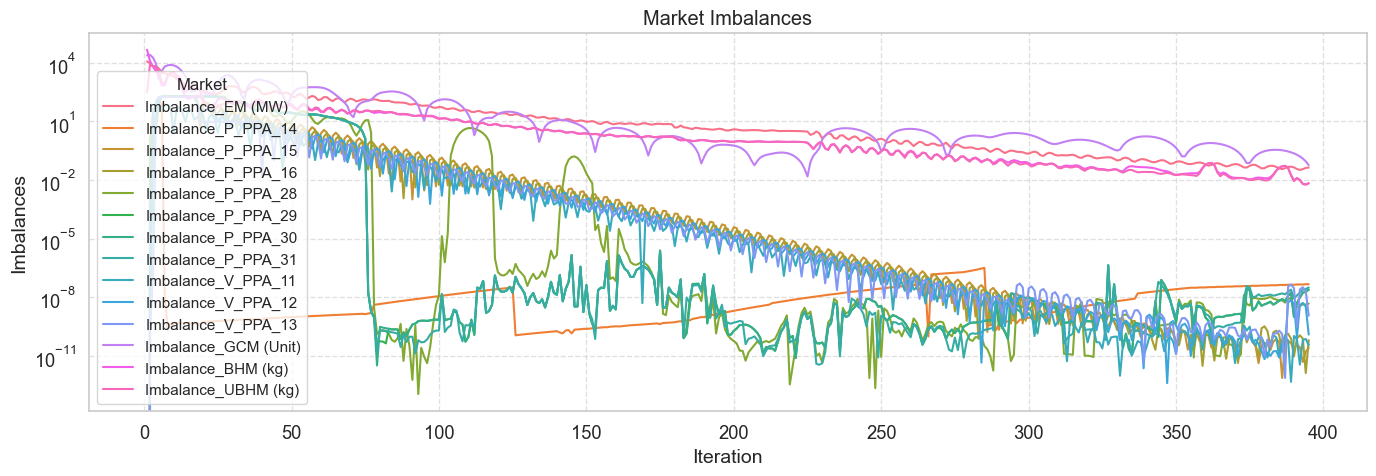

In [16]:
# Results
imbalance_cols = [col for col in df_log.columns if col.startswith('Imbalance_')]
df_melted = df_log.melt(
    id_vars='Iter',
    value_vars=imbalance_cols,
    var_name='Market',
    value_name='Imbalance')
market_label_map = {
    'Imbalance_EM': 'Imbalance_EM (MW)',
    'Imbalance_GCM': 'Imbalance_GCM (Unit)',
    'Imbalance_BHM': 'Imbalance_BHM (kg)',
    'Imbalance_UBHM': 'Imbalance_UBHM (kg)'}
df_melted['Market'] = df_melted['Market'].apply(lambda x: market_label_map.get(x, x))
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.figure(figsize=(14, 5))
plt.yscale('log')
sns.lineplot(
    data=df_melted,
    x='Iter',
    y='Imbalance',
    linewidth=1.5,
    hue='Market')
plt.title('Market Imbalances')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Imbalances', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Market', title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.show()

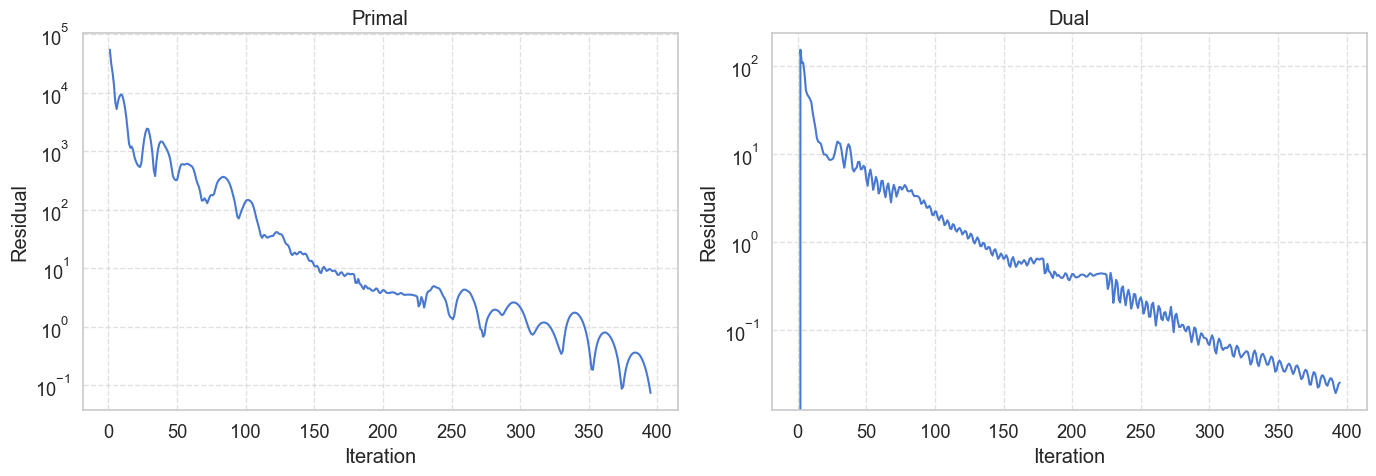

In [17]:
# Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 
sns.lineplot(data=df_log, x='Iter', y='Primal_Res', ax=axes[0])
axes[0].set_title('Primal')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Residual')
axes[0].set_yscale('log')
axes[0].grid(True, linestyle='--', alpha=0.6)
sns.lineplot(data=df_log, x='Iter', y='Dual_Res', ax=axes[1])
axes[1].set_title('Dual')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Residual')
axes[1].set_yscale('log')
axes[1].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

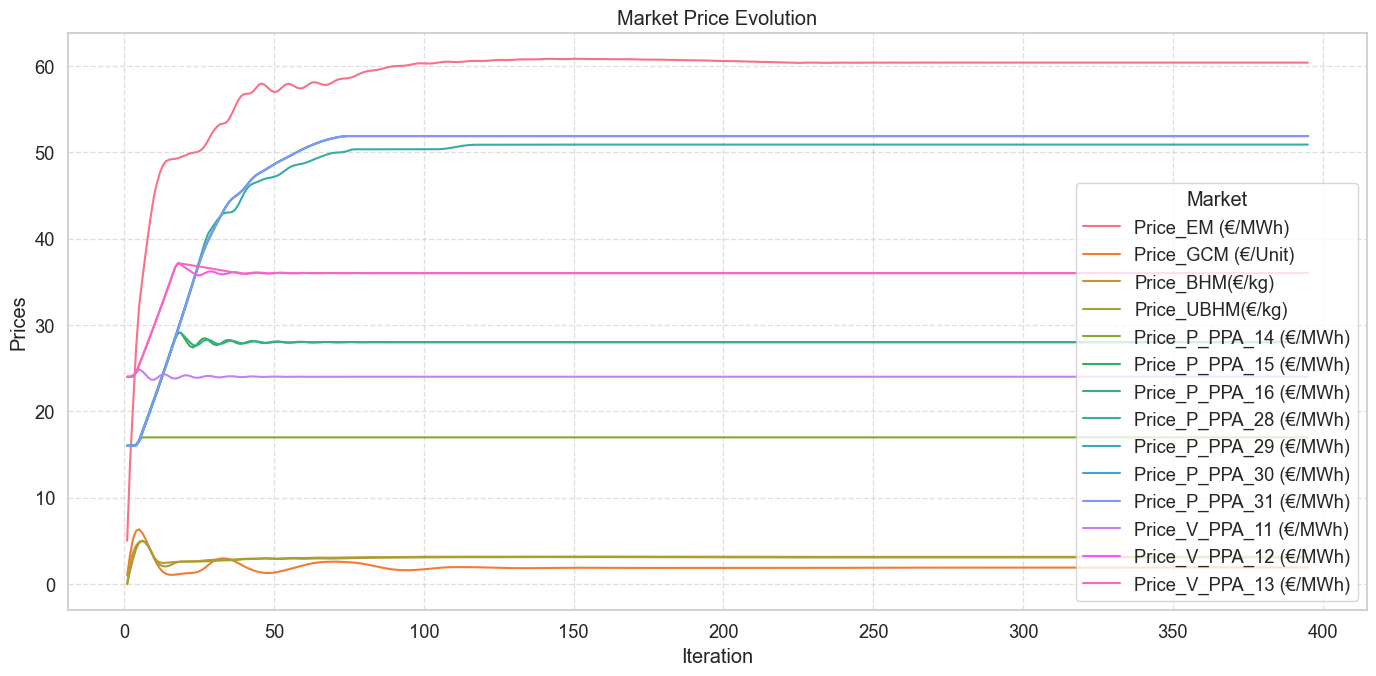

In [18]:
# Price Update
rename_dict = {
    'Price_EM': 'Price_EM (€/MWh)',
    'Price_GCM': 'Price_GCM (€/Unit)', 
    'Price_BHM': 'Price_BHM(€/kg)',
    'Price_UBHM': 'Price_UBHM(€/kg)'
}
for a in model.P_PPA_Mix:
    rename_dict[f'Price_P_PPA_{a}'] = f'Price_P_PPA_{a} (€/MWh)'
for a in model.RU_TypeB:
    rename_dict[f'Price_V_PPA_{a}'] = f'Price_V_PPA_{a} (€/MWh)'
df_price_renamed = df_log.rename(columns=rename_dict)
plt.figure(figsize=(14, 7))
price_cols = ['Iter']
price_cols.extend([col for col in [
    'Price_EM (€/MWh)',
    'Price_GCM (€/Unit)',
    'Price_BHM(€/kg)',
    'Price_UBHM(€/kg)'
] if col in df_price_renamed.columns])
for a in model.P_PPA_Mix:
    col = f'Price_P_PPA_{a} (€/MWh)'
    if col in df_price_renamed.columns:
        price_cols.append(col)
for a in model.RU_TypeB:
    col = f'Price_V_PPA_{a} (€/MWh)' 
    if col in df_price_renamed.columns:
        price_cols.append(col)
sns.lineplot(
    data=df_price_renamed[price_cols].melt(
        id_vars='Iter',
        var_name='Market',
        value_name='Price'
    ),
    x='Iter',
    y='Price',
    hue='Market'
)
plt.title('Market Price Evolution')
plt.xlabel('Iteration')
plt.ylabel('Prices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [19]:
# Market Table
for idx in model.s:
    print(f'\n=== Market Table for Scenario {idx} ===')
    df = pd.DataFrame()
    for i in model.RU_TypeC:
        df.at[f'RU_TypeC_{i}', 'GCM'] = round(model_RU_TypeC.q_GCM[i, idx].value, 3)
    for i in model.HE_TypeA:
        df.at[f'HE_TypeA_{i}', 'GCM'] = round(model_HE_TypeA.q_GCM_Portfolio[i, idx].value, 3)
    for i in model.HE_TypeB:
        df.at[f'HE_TypeB_{i}', 'GCM'] = round(model_HE_TypeB.q_GCM[i, idx].value, 3)
    for i in model.HE_TypeC:
        df.at[f'HE_TypeC_{i}', 'GCM'] = round(model_HE_TypeC.q_GCM[i, idx].value, 3)
    for i in model.RU_TypeD:
        df.at[f'RU_TypeD_{i}', 'GCM'] = round(model_RU_TypeD.q_GCM[i, idx].value, 3)
    df.at['Demand', 'GCM'] = round(model.RoM_GCM.value, 3)
    for i in model.RU_TypeB:
        df.at[f'V_PPA_{i}', 'V-PPA'] = round(sum(model_RU_TypeB.q_V_PPA[i, idx].value * model.PF[i, t, idx].value * model.Error[i, idx].value for t in model.t), 3)
    for i in model.HE_TypeA:
        for a in model.RU_TypeB:
            df.at[f'HE_TypeA_{i}', f'V-PPA_{a}'] = round(sum((model_HE_TypeA.V_PPA_VaR[i, a].value + model_HE_TypeA.delta_V_PPA[i, a, idx].value) * model.PF[a, t, idx].value * model.Error[a, idx].value for t in model.t), 3)
    for i in model.HE_TypeB:
            for a in model.RU_TypeB:
                df.at[f'HE_TypeB_{i}', f'V-PPA_{a}'] = round(sum(model_HE_TypeB.q_V_PPA[i, idx, a].value * model.PF[a, t, idx].value * model.Error[a, idx].value for t in model.t), 3)
    for i in model.RU_TypeB:
        df.at['Demand', f'V-PPA_{i}'] = round(sum(model.RoM_V_PPA[i] * model.PF[i, t, idx].value * model.Error[i, idx].value for t in model.t), 3)
    for i in model.RU_TypeA:
        df.at[f'P_PPA_{i}', 'P-PPA'] = round(sum(model_RU_TypeA.q_P_PPA[i, idx].value * model.PF[i, t, idx].value * model.Error[i, idx].value for t in model.t), 3)
    for i in model.RU_TypeD:
        df.at[f'RU_TypeD_{i}', 'P-PPA'] = round(sum(model_RU_TypeD.q_P_PPA[i, idx].value * model.PF[i, t, idx].value * model.Error[i, idx].value for t in model.t), 3)
    for i in model.HE_TypeA:
        for a in model.P_PPA_Mix:
            df.at[f'HE_TypeA_{i}', f'P-PPA_{a}'] = round(sum((model_HE_TypeA.P_PPA_VaR[i, a].value + model_HE_TypeA.delta_P_PPA[i, a, idx].value) * model.PF[a, t, idx].value for t in model.t), 3)
    for i in model.HE_TypeB:
        for a in model.P_PPA_Mix:
            df.at[f'HE_TypeB_{i}', f'P-PPA_{a}'] = round(sum(model_HE_TypeB.q_P_PPA[i, idx, a].value * model.PF[a, t, idx].value * model.Error[a, idx].value for t in model.t), 3)
    for i in model.P_PPA_Mix:
        df.at['Demand', f'P-PPA_{i}'] = round(sum(model.RoM_P_PPA[i] * model.PF[i, t, idx].value * model.Error[i, idx].value for t in model.t), 3)
    for i in model.TU:
        df.at[f'TU_{i}', 'Energy'] = round(sum(model_TU.q_EM[i,t, idx].value for t in model.t), 3)
    for i in model.RU_TypeC:
        df.at[f'RU_TypeC_{i}', 'Energy'] = round(sum(model_RU_TypeC.q_EM[i,t, idx].value for t in model.t), 3)
    for i in model.HE_TypeA:
        df.at[f'HE_TypeA_{i}', 'Energy'] = round(sum(model_HE_TypeA.q_EM_Portfolio[i,t, idx].value for t in model.t), 3)
    for i in model.HE_TypeB:
        df.at[f'HE_TypeB_{i}', 'Energy'] = round(sum(model_HE_TypeB.q_EM[i,t, idx].value for t in model.t), 3)
    for i in model.RU_TypeD:
        df.at[f'RU_TypeD_{i}', 'Energy'] = round(sum(model_RU_TypeD.q_EM[i,t, idx].value for t in model.t), 3)
    df.at['Demand', 'Energy'] = round(sum(model.RoM_EM[t] for t in model.t), 3)
    for i in model.HE_TypeA:
        df.at[f'HE_TypeA_{i}', 'Hydrogen (BHM)'] = round(sum(model_HE_TypeA.q_BHM_Portfolio[i,t, idx].value for t in model.t), 3)
    for i in model.HE_TypeB:
        df.at[f'HE_TypeB_{i}', 'Hydrogen (BHM)'] = round(sum(model_HE_TypeB.q_BHM[i,t, idx].value for t in model.t), 3)
    for i in model.HE_TypeC:
        df.at[f'HE_TypeC_{i}', 'Hydrogen (BHM)'] = round(sum(model_HE_TypeC.q_BHM[i,t, idx].value for t in model.t), 3)
    df.at['Demand', 'Hydrogen (BHM)'] = round(sum(model.RoM_BHM[t] for t in model.t), 3)
    for i in model.HE_TypeA:
        df.at[f'HE_TypeA_{i}', 'Hydrogen (UBHM)'] = round(sum(model_HE_TypeA.q_UBHM_Portfolio[i,t, idx].value for t in model.t), 3)
    for i in model.HE_TypeB:
        df.at[f'HE_TypeB_{i}', 'Hydrogen (UBHM)'] = round(sum(model_HE_TypeB.q_UBHM[i,t, idx].value for t in model.t), 3)
    for i in model.HE_TypeC:
        df.at[f'HE_TypeC_{i}', 'Hydrogen (UBHM)'] = round(sum(model_HE_TypeC.q_UBHM[i,t, idx].value for t in model.t), 3)
    df.at['Demand', 'Hydrogen (UBHM)'] = round(sum(model.RoM_UBHM[t] for t in model.t), 3)
    demand_row = df.loc['Demand'].copy()
    df = df.drop('Demand')
    separator = pd.Series(['-' * 10] * len(df.columns), index=df.columns, name='-----------')
    df = pd.concat([df, pd.DataFrame([separator, demand_row])])
    print(tabulate(df, headers='keys', tablefmt='pretty', stralign='center', numalign='center'))
print("\n" * 1)
print('Number of Iterations:',it)
print('Solution Time:',total_time,'(s)')


=== Market Table for Scenario 1 ===
+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------------+-----------------+
|             |    GCM     |   V-PPA    |  V-PPA_11  |  V-PPA_12  |  V-PPA_13  |   P-PPA    |  P-PPA_14  |  P-PPA_15  |  P-PPA_16  |  P-PPA_28  |  P-PPA_29  |  P-PPA_30  |  P-PPA_31  |   Energy   | Hydrogen (BHM) | Hydrogen (UBHM) |
+-------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------------+-----------------+
| RU_TypeC_7  |  1005.789  |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |    nan     |  1005.789  |      nan       |       nan       |
| RU_TypeC_8  |  2068.777  |   


=== Price Curves for Scenario 1 ===



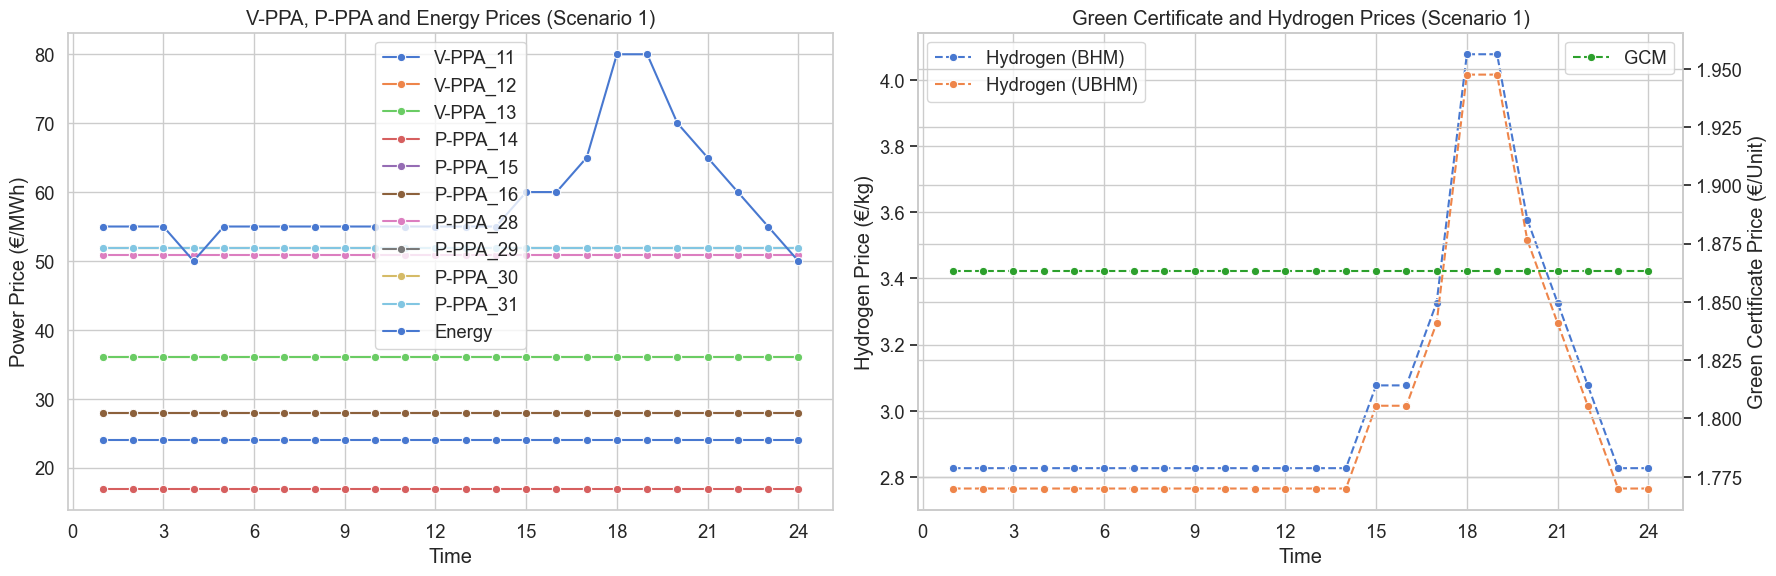


=== Price Curves for Scenario 2 ===



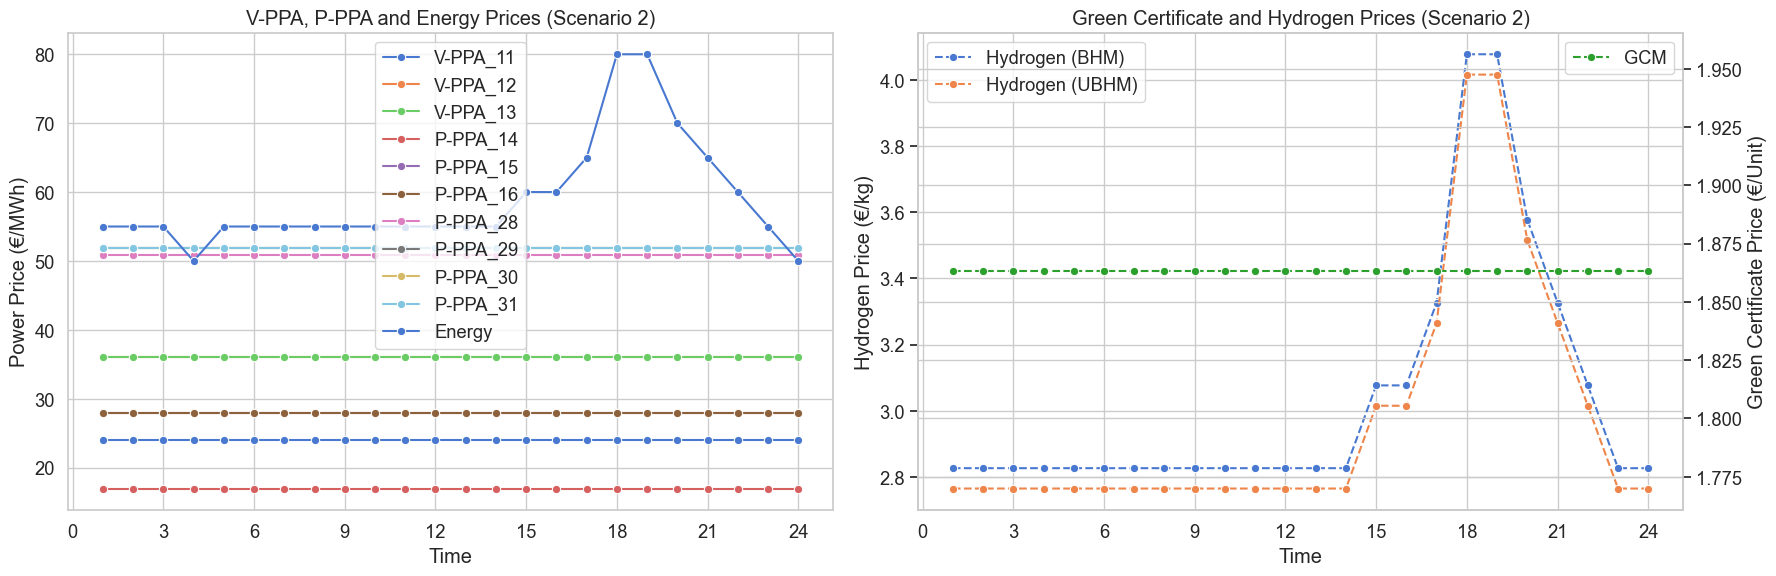


=== Price Curves for Scenario 3 ===



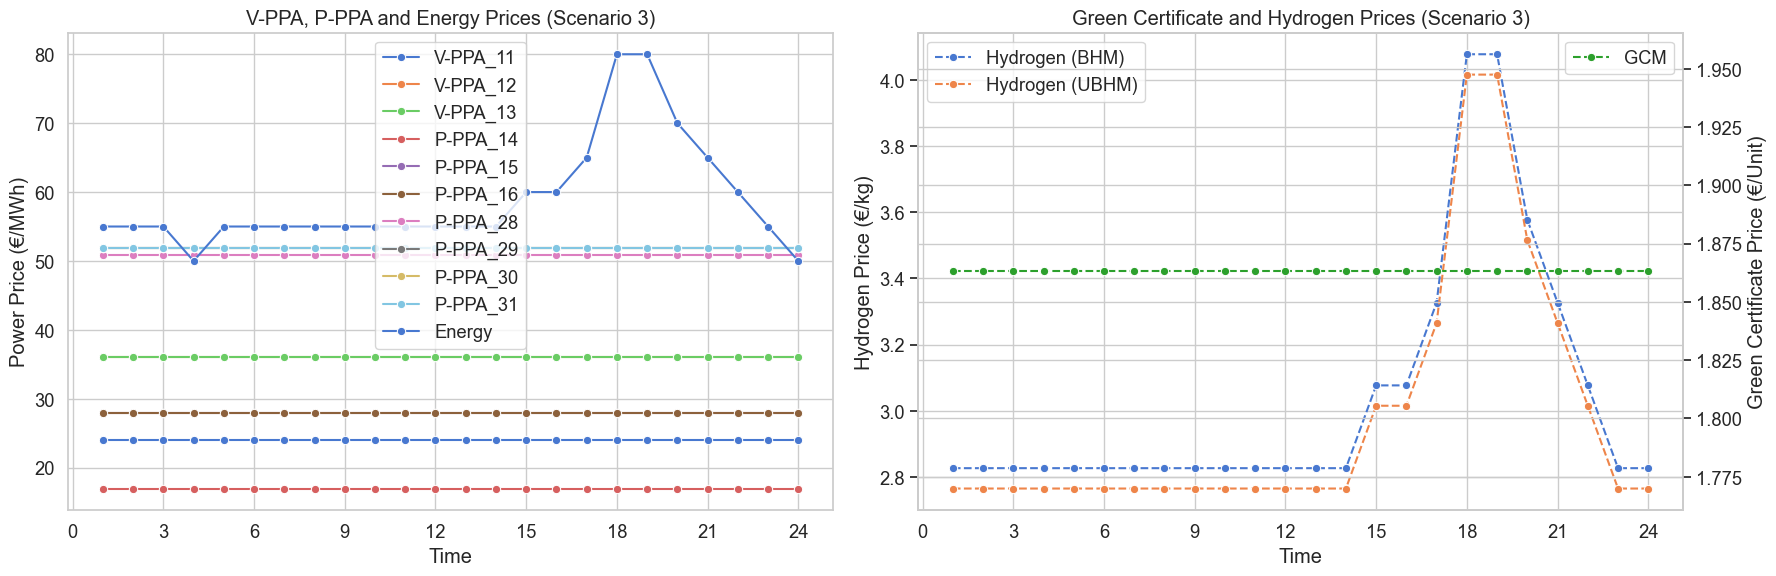


=== Price Curves for Scenario 4 ===



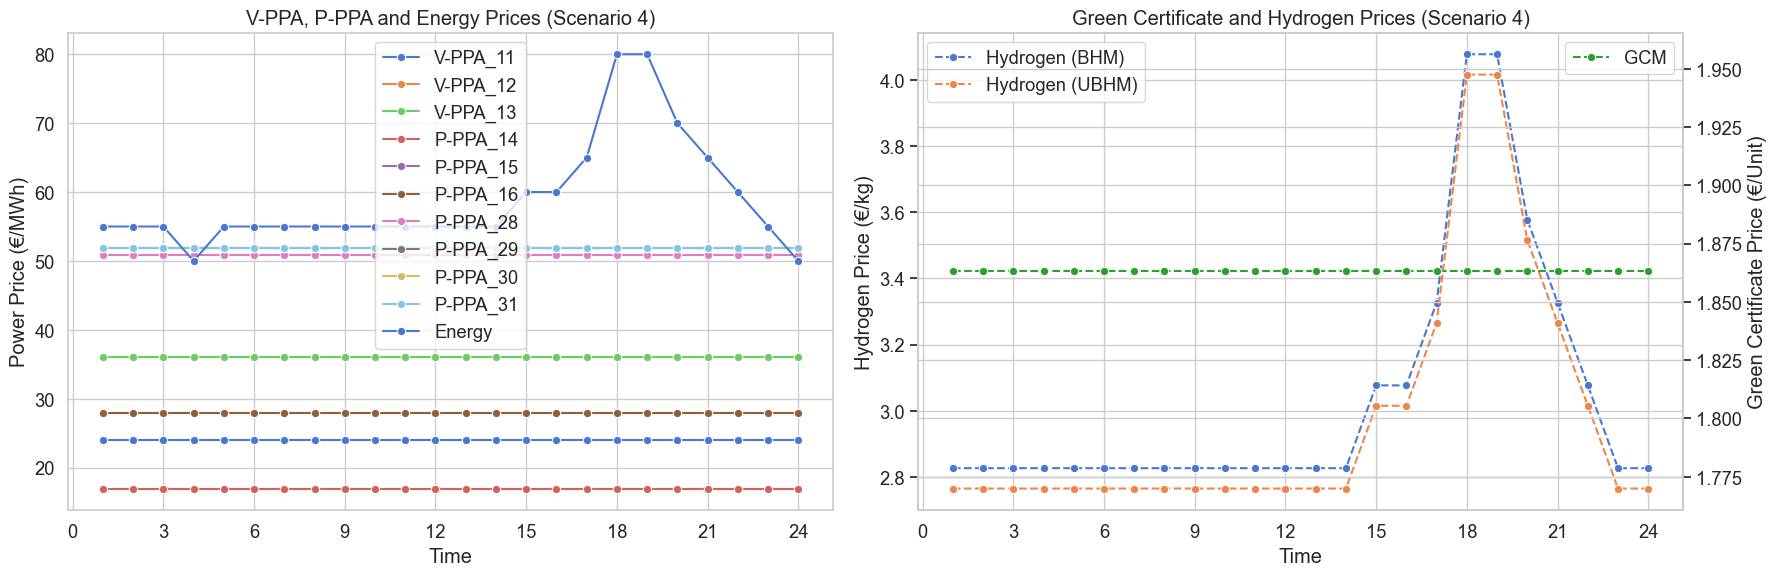


=== Price Curves for Scenario 5 ===



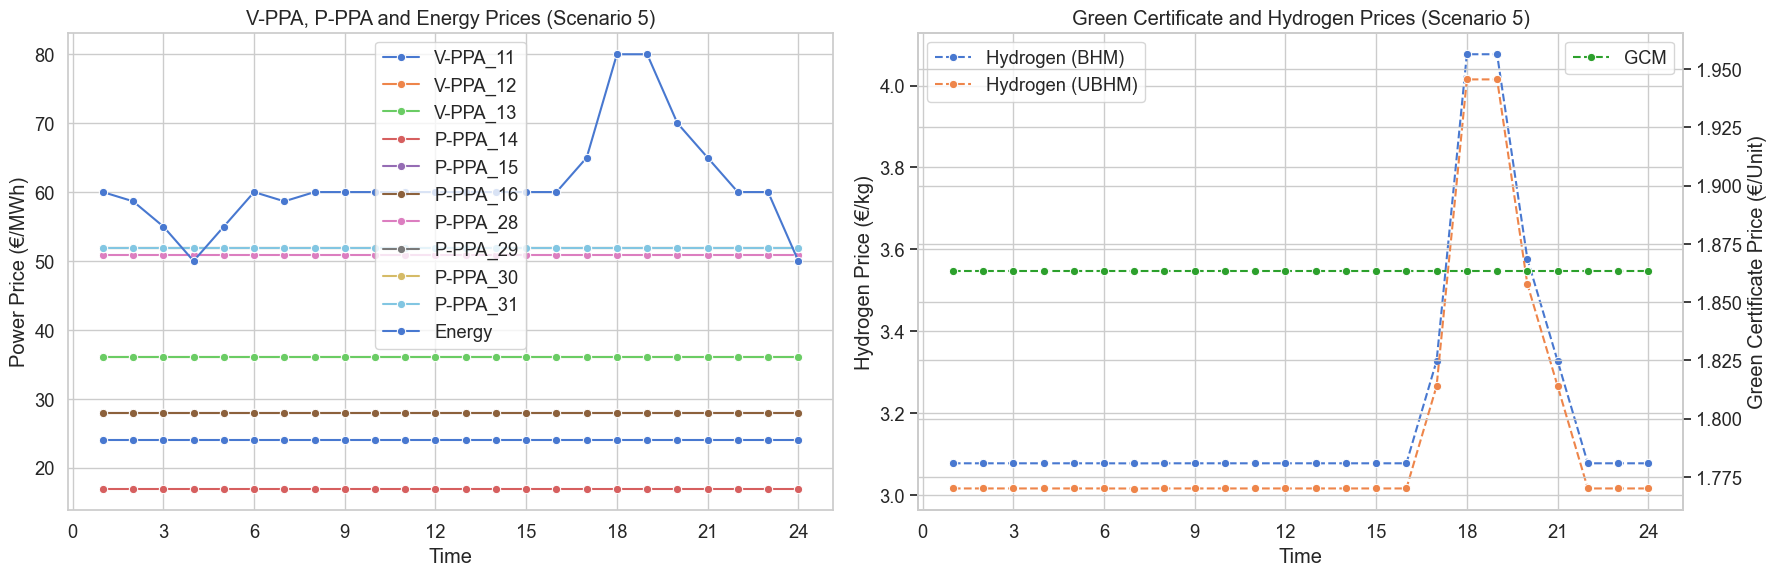


=== Price Curves for Scenario 6 ===



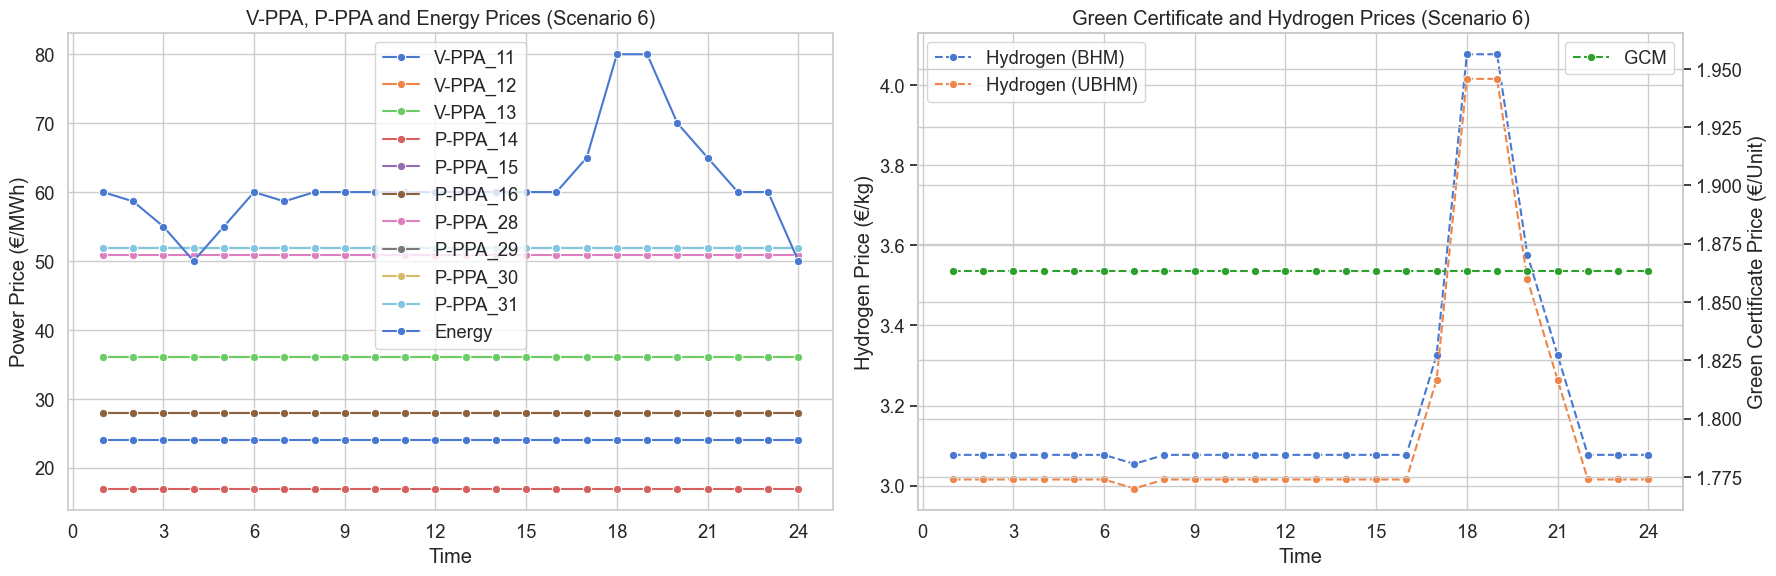


=== Price Curves for Scenario 7 ===



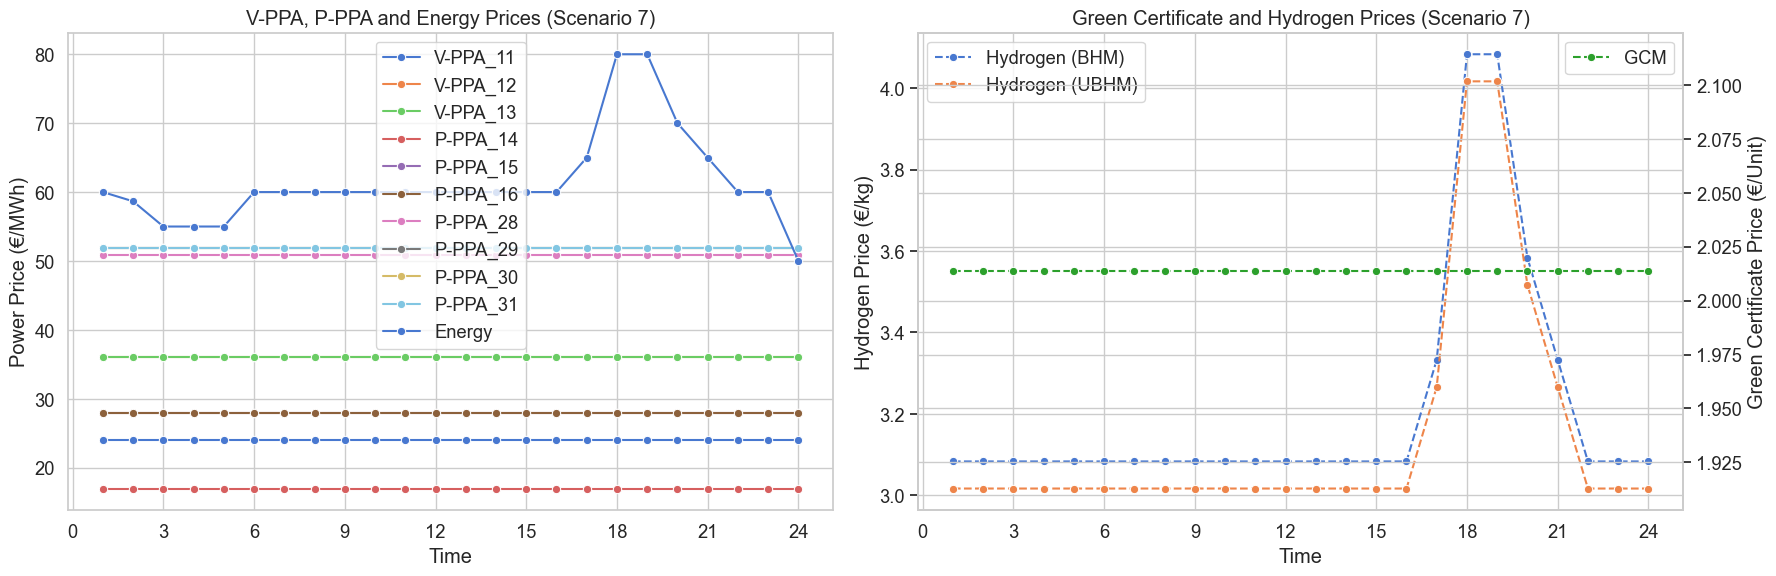


=== Price Curves for Scenario 8 ===



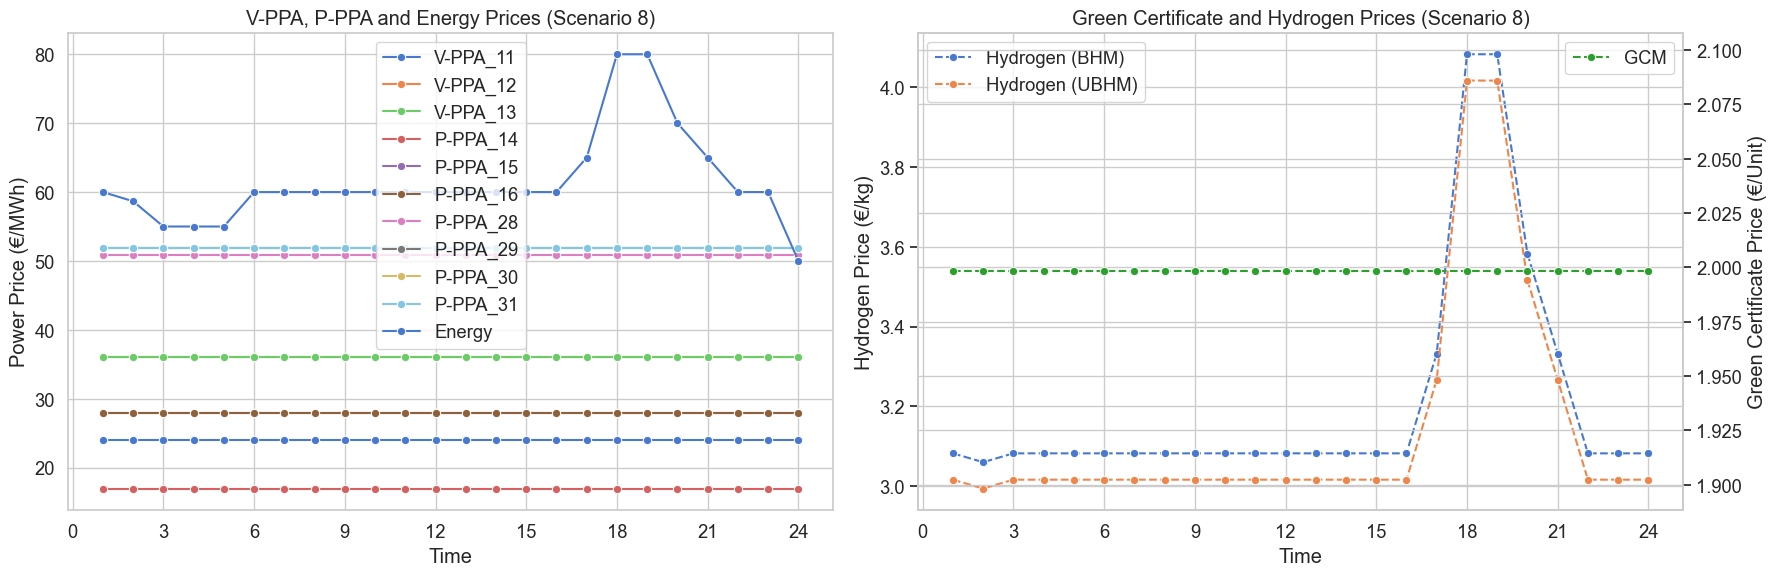


=== Price Curves for Scenario 9 ===



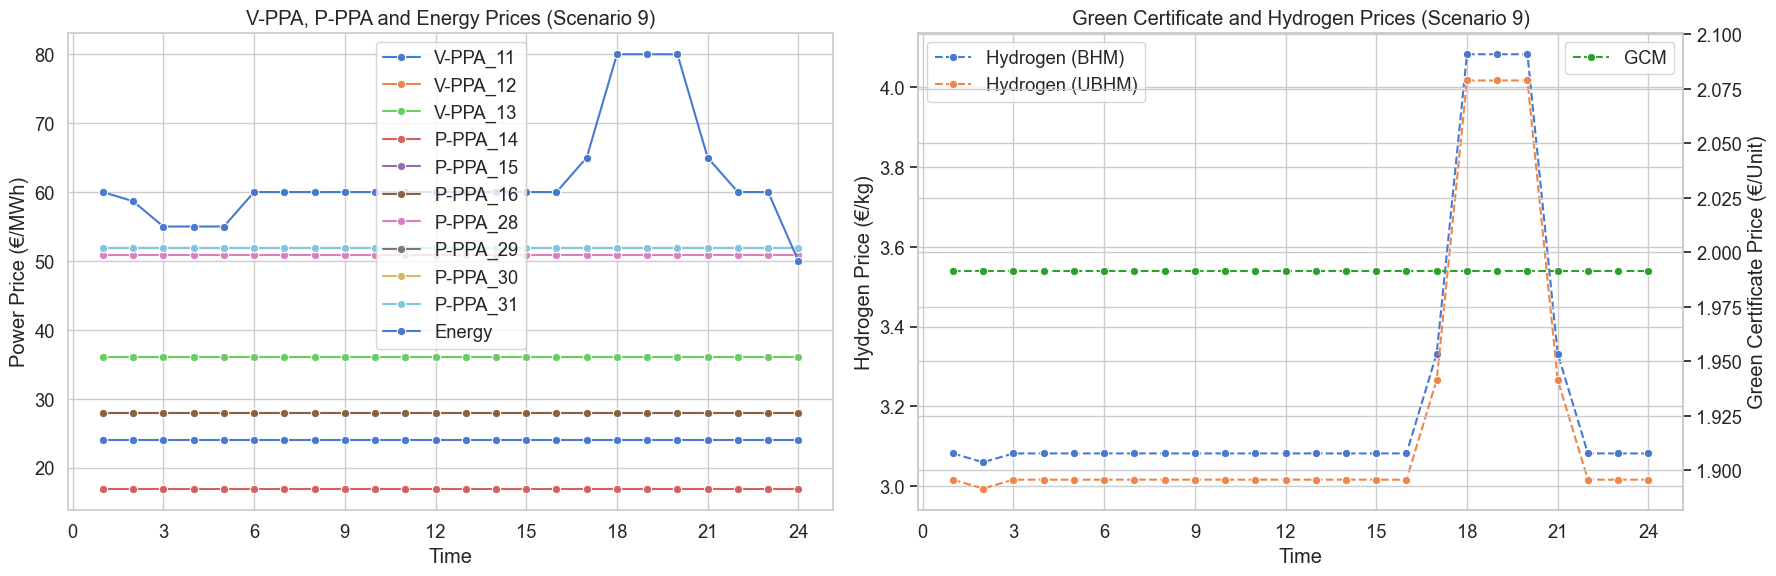


=== Price Curves for Scenario 10 ===



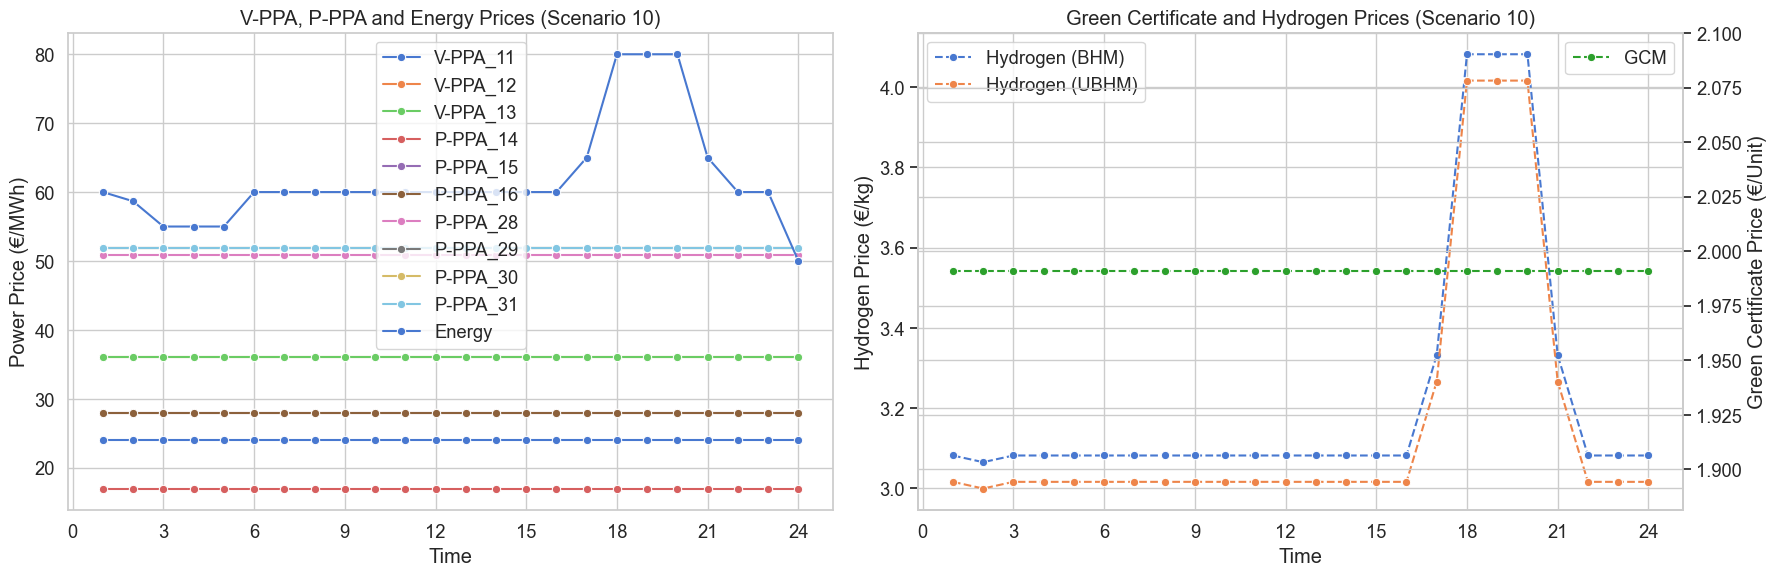

In [20]:
# Price Curves
for idx in model.s:
    print(f'\n=== Price Curves for Scenario {idx} ===\n')
    time_steps = list(model.t)
    df_prices_t = pd.DataFrame(index=time_steps)
    df_prices_t.index.name = 'Time'
    df_prices_t['GCM'] = [model.lambda_GCM[idx].value for t in model.t]
    for a in model.RU_TypeB:
        df_prices_t[f'V-PPA_{a}'] = [model.lambda_V_PPA[idx, a].value for t in model.t]
    for a in model.P_PPA_Mix:
        df_prices_t[f'P-PPA_{a}'] = [model.lambda_P_PPA[idx, a].value for t in model.t]
    df_prices_t['Energy'] = [model.lambda_EM[t, idx].value for t in model.t]
    df_prices_t['Hydrogen (BHM)'] = [model.lambda_H2_BD[t, idx].value for t in model.t]
    df_prices_t['Hydrogen (UBHM)'] = [model.lambda_H2_UBD[t, idx].value for t in model.t]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    sns.set_style("whitegrid")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    for a in model.RU_TypeB:
        sns.lineplot(x=df_prices_t.index, y=df_prices_t[f'V-PPA_{a}'], ax=ax1, marker='o', label=f'V-PPA_{a}')
    for a in model.P_PPA_Mix:
        sns.lineplot(x=df_prices_t.index, y=df_prices_t[f'P-PPA_{a}'], ax=ax1, marker='o', label=f'P-PPA_{a}')
    sns.lineplot(x=df_prices_t.index, y=df_prices_t['Energy'], ax=ax1, marker='o', label='Energy')
    ax1.set_ylabel("Power Price (€/MWh)")
    ax1.set_xlabel("Time")
    ax1.set_title(f"V-PPA, P-PPA and Energy Prices (Scenario {idx})")
    ax1.legend()
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    sns.lineplot(x=df_prices_t.index, y=df_prices_t['Hydrogen (BHM)'], ax=ax2, marker='o', linestyle='--', label='Hydrogen (BHM)')
    sns.lineplot(x=df_prices_t.index, y=df_prices_t['Hydrogen (UBHM)'], ax=ax2, marker='o', linestyle='--', label='Hydrogen (UBHM)')
    ax2.set_ylabel("Hydrogen Price (€/kg)")
    ax2.set_xlabel("Time")
    ax2.set_title(f"Green Certificate and Hydrogen Prices (Scenario {idx})")
    ax2b = ax2.twinx()
    sns.lineplot(x=df_prices_t.index, y=df_prices_t['GCM'], ax=ax2b, marker='o', linestyle='--', color='tab:green', label='GCM')
    ax2b.set_ylabel("Green Certificate Price (€/Unit)")
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='upper left')
    plt.tight_layout()
    plt.show()

In [21]:
# Price Table
for idx in model.s:
    print(f'\n=== Price Table for Scenario {idx} ===')
    df_prices_t = pd.DataFrame(index=[t for t in model.t])
    df_prices_t['GCM'] = model.lambda_GCM[idx].value
    for a in model.RU_TypeB:
        df_prices_t[f'V-PPA_{a}'] = [model.lambda_V_PPA[idx, a].value for t in model.t]
    for a in model.P_PPA_Mix:
        df_prices_t[f'P-PPA_{a}'] = [model.lambda_P_PPA[idx, a].value for t in model.t]
    df_prices_t['Energy'] = [model.lambda_EM[t, idx].value for t in model.t]
    df_prices_t['Hydrogen (BHM)'] = [model.lambda_H2_BD[t, idx].value for t in model.t]
    df_prices_t['Hydrogen (UBHM)'] = [model.lambda_H2_UBD[t, idx].value for t in model.t]
    df_prices_t = df_prices_t.reset_index().rename(columns={'index': 'Time'})
    df_prices_t['Time'] = df_prices_t['Time'].astype(int)
    df_to_print = df_prices_t.copy()
    df_to_print['Time'] = df_to_print['Time'].astype(str)
    print(tabulate(df_to_print, headers='keys', tablefmt='grid', showindex=False, stralign="center", numalign="center", floatfmt=".2f"))


=== Price Table for Scenario 1 ===
+--------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------+------------------+-------------------+
|  Time  |  GCM  |  V-PPA_11  |  V-PPA_12  |  V-PPA_13  |  P-PPA_14  |  P-PPA_15  |  P-PPA_16  |  P-PPA_28  |  P-PPA_29  |  P-PPA_30  |  P-PPA_31  |  Energy  |  Hydrogen (BHM)  |  Hydrogen (UBHM)  |
+========+=======+============+============+============+============+============+============+============+============+============+============+==========+==================+===================+
|   1    | 1.86  |   24.00    |   36.00    |   36.00    |   16.98    |   28.00    |   28.00    |   50.88    |   51.87    |   51.87    |   51.87    |  55.00   |       2.83       |       2.77        |
+--------+-------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------+---------

In [22]:
with pd.ExcelWriter("Outputs_C9.xlsx") as writer:
    rows = []
    rows.append({
        'Total Cost': sum(sum(model.Prob[s] * model_HE_TypeA.Z_HE_TypeA[a, s].value for s in model.s) for a in model.HE_TypeA)
        })
    df = pd.DataFrame(rows)
    sheet_name = f"Risk_HE_TypeA"
    df.to_excel(writer, sheet_name=sheet_name, index=False)

    rows = []
    for s in model.s:
        rows.append({
            's': s,
            'Total Cost': sum(model_HE_TypeA.Z_HE_TypeA[a, s].value for a in model.HE_TypeA)
        })
    df = pd.DataFrame(rows)
    sheet_name = f"Scenarios_HE_TypeA"
    df.to_excel(writer, sheet_name=sheet_name, index=False)

    for a in model.HE_TypeA:
        rows = []
        rows.append({
            'Total Cost': sum(model.Prob[s] * model_HE_TypeA.Z_HE_TypeA[a, s].value for s in model.s),
            'CVaR_P-PPA': sum(model_HE_TypeA.P_PPA_CVaR[a, aa].value for aa in model.P_PPA_Mix),
            'CVaR_V-PPA': sum(model_HE_TypeA.V_PPA_CVaR[a, aa].value for aa in model.RU_TypeB),
            'VaR_P-PPA': sum(model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.P_PPA_Mix),
            'VaR_V-PPA': sum(model_HE_TypeA.V_PPA_VaR[a, aa].value for aa in model.RU_TypeB),
            'NU_P-PPA': sum(model.Prob[s] * sum(model_HE_TypeA.q_P_PPA[a, s, aa].value - model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.P_PPA_Mix) for s in model.s),
            'NU_V-PPA': sum(model.Prob[s] * sum(model_HE_TypeA.q_V_PPA[a, s, aa].value - model_HE_TypeA.V_PPA_VaR[a, aa].value for aa in model.RU_TypeB) for s in model.s),
            'RL_P-PPA': sum(model.Prob[s] * sum(model_HE_TypeA.delta_P_PPA[a, aa, s].value for aa in model.P_PPA_Mix) for s in model.s),
            'RL_V-PPA': sum(model.Prob[s] * sum(model_HE_TypeA.delta_V_PPA[a, aa, s].value for aa in model.RU_TypeB) for s in model.s)
            })
        df = pd.DataFrame(rows)
        sheet_name = f"Risk_HE_TypeA_{a}"
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    for a in model.HE_TypeA:
        rows = []
        rows.append({
            'Total Cost': sum(model.Prob[s] * model_HE_TypeA.Z_HE_TypeA[a, s].value for s in model.s),
            'CVaR_Wind': sum(model_HE_TypeA.P_PPA_CVaR[a, aa].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 1) + sum(model_HE_TypeA.P_PPA_CVaR[a, aa].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 1) + sum(model_HE_TypeA.V_PPA_CVaR[a, aa].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 1),
            'CVaR_PV': sum(model_HE_TypeA.V_PPA_CVaR[a, aa].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 2) + sum(model_HE_TypeA.P_PPA_CVaR[a, aa].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 2) + sum(model_HE_TypeA.P_PPA_CVaR[a, aa].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 2),
            'VaR_Wind': sum(model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 1) + sum(model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 1) + sum(model_HE_TypeA.V_PPA_VaR[a, aa].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 1),
            'VaR_PV': sum(model_HE_TypeA.V_PPA_VaR[a, aa].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 2) + sum(model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 2) + sum(model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 2),
            'NU_Wind': sum(model.Prob[s] * sum(model_HE_TypeA.q_P_PPA[a, s, aa].value - model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 1) for s in model.s) + sum(model.Prob[s] * sum(model_HE_TypeA.q_P_PPA[a, s, aa].value - model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 1) for s in model.s) + \
            sum(model.Prob[s] * sum(model_HE_TypeA.q_V_PPA[a, s, aa].value - model_HE_TypeA.V_PPA_VaR[a, aa].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 1) for s in model.s),
            'NU_PV': sum(model.Prob[s] * sum(model_HE_TypeA.q_V_PPA[a, s, aa].value - model_HE_TypeA.V_PPA_VaR[a, aa].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 2) for s in model.s) + sum(model.Prob[s] * sum(model_HE_TypeA.q_P_PPA[a, s, aa].value - model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 2) for s in model.s) + \
            sum(model.Prob[s] * sum(model_HE_TypeA.q_P_PPA[a, s, aa].value - model_HE_TypeA.P_PPA_VaR[a, aa].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 2) for s in model.s),
            'RL_Wind': sum(model.Prob[s] * sum(model_HE_TypeA.delta_P_PPA[a, aa, s].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 1) for s in model.s) + sum(model.Prob[s] * sum(model_HE_TypeA.delta_P_PPA[a, aa, s].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 1) for s in model.s) + \
            sum(model.Prob[s] * sum(model_HE_TypeA.delta_V_PPA[a, aa, s].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 1) for s in model.s),
            'RL_PV': sum(model.Prob[s] * sum(model_HE_TypeA.delta_V_PPA[a, aa, s].value for aa in model.RU_TypeB if Data_RU_TypeB.at[aa-10, 'Type'] == 2) for s in model.s) + sum(model.Prob[s] * sum(model_HE_TypeA.delta_P_PPA[a, aa, s].value for aa in model.RU_TypeA if Data_RU_TypeA.at[aa-13, 'Type'] == 2) for s in model.s) + \
            sum(model.Prob[s] * sum(model_HE_TypeA.delta_P_PPA[a, aa, s].value for aa in model.RU_TypeD if Data_RU_TypeD.at[aa-27, 'Type'] == 2) for s in model.s)
            })
        df = pd.DataFrame(rows)
        sheet_name = f"Risk_HE_TypeA__{a}"
        df.to_excel(writer, sheet_name=sheet_name, index=False) 

    df_log.to_excel(writer, sheet_name="Log", index=False)